# 종속 라이브러리 설치

In [1]:
# !pip install easydict
# !apt install libfreetype6-dev -y

# 데이터 살펴보기

In [2]:
from pycocotools.coco import COCO

In [3]:
ROOT = 'dataset/Fashion2021'
train = COCO(f'{ROOT}/annotations/instances_train.json')

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


### 카테고리

In [4]:
# 0번은 background
train.cats

{1: {'supercategory': 'top', 'id': 1, 'name': 'top'},
 2: {'supercategory': 'bottom', 'id': 2, 'name': 'bottom'},
 3: {'supercategory': 'dress', 'id': 3, 'name': 'dress'},
 4: {'supercategory': 'outer', 'id': 4, 'name': 'outer'}}

### 이미지 정보

In [6]:
train.imgs

{917510: {'file_name': 'train_00001.jpg',
  'height': 1200,
  'width': 800,
  'id': 917510},
 655373: {'file_name': 'train_00002.jpg',
  'height': 800,
  'width': 800,
  'id': 655373},
 917522: {'file_name': 'train_00003.jpg',
  'height': 533,
  'width': 800,
  'id': 917522},
 1048598: {'file_name': 'train_00004.jpg',
  'height': 1049,
  'width': 800,
  'id': 1048598},
 524311: {'file_name': 'train_00005.jpg',
  'height': 800,
  'width': 800,
  'id': 524311},
 589851: {'file_name': 'train_00006.jpg',
  'height': 1200,
  'width': 800,
  'id': 589851},
 1310748: {'file_name': 'train_00007.jpg',
  'height': 800,
  'width': 800,
  'id': 1310748},
 983071: {'file_name': 'train_00008.jpg',
  'height': 1066,
  'width': 800,
  'id': 983071},
 458786: {'file_name': 'train_00009.jpg',
  'height': 1066,
  'width': 800,
  'id': 458786},
 1245221: {'file_name': 'train_00010.jpg',
  'height': 1066,
  'width': 800,
  'id': 1245221},
 1179686: {'file_name': 'train_00011.jpg',
  'height': 1049,
  'widt

### 각 이미지에 해당하는 Annotation

In [8]:
train.anns

{1: {'area': 12636,
  'iscrowd': 0,
  'image_id': 917510,
  'bbox': [307.5, 709.833, 162, 78],
  'category_id': 2,
  'id': 1},
 2: {'area': 109020,
  'iscrowd': 0,
  'image_id': 917510,
  'bbox': [177.5, 441.833, 345, 316],
  'category_id': 1,
  'id': 2},
 3: {'area': 37698,
  'iscrowd': 0,
  'image_id': 655373,
  'bbox': [318.573, 369.261, 122, 309],
  'category_id': 2,
  'id': 3},
 4: {'area': 19740,
  'iscrowd': 0,
  'image_id': 655373,
  'bbox': [279.012, 269.759, 141, 140],
  'category_id': 1,
  'id': 4},
 5: {'area': 6097,
  'iscrowd': 0,
  'image_id': 917522,
  'bbox': [375.5, 280.5, 91, 67],
  'category_id': 2,
  'id': 5},
 6: {'area': 22500,
  'iscrowd': 0,
  'image_id': 917522,
  'bbox': [361.5, 153.5, 125, 180],
  'category_id': 1,
  'id': 6},
 7: {'area': 96960,
  'iscrowd': 0,
  'image_id': 1048598,
  'bbox': [281.625, 425.094, 240, 404],
  'category_id': 2,
  'id': 7},
 8: {'area': 36720,
  'iscrowd': 0,
  'image_id': 1048598,
  'bbox': [305.625, 249.262, 180, 204],
  'ca

### 이미지에 바운딩 박스를 그려주는 함수 정의

In [10]:
import imgaug
import numpy as np
from PIL import Image
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
def draw_anns(data, ann_id, split='train'):
    ann = data.anns[ann_id]
    image_id = ann['image_id']
    x, y, w, h = ann['bbox']
    cat_id = ann['category_id']
    label = data.cats[cat_id]['name']
    file_name = data.imgs[image_id]['file_name']
    file_path = f'{ROOT}/{split}/{file_name}'
    image = np.array(Image.open(file_path).convert('RGB'))
    bbox = BoundingBoxesOnImage([
        BoundingBox(x1=x, y1=y, x2=x+w, y2=y+h, label=label)
        ], shape=image.shape)
    out = bbox.draw_on_image(image)
    return Image.fromarray(out)
    

### 데이터 확인

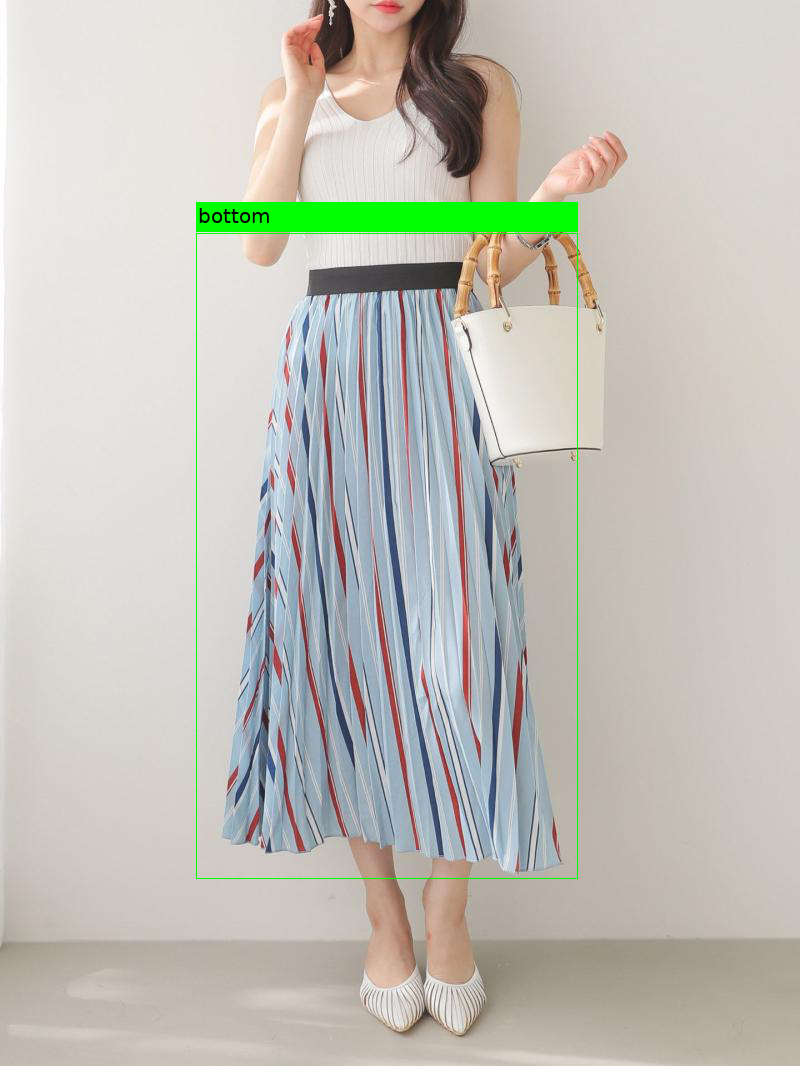

In [11]:
draw_anns(train, ann_id=120, split='train')

# Train

### 학습에 필요한 모듈 및 라이브러리 추가

In [12]:
import os
import argparse
import time
import yaml
import logging
from collections import OrderedDict
from contextlib import suppress
from datetime import datetime

import torch
import torchvision.utils

from effdet import get_efficientdet_config, create_model, unwrap_bench, create_loader, create_dataset, create_evaluator
from effdet.config.model_config import efficientdet_model_param_dict
from effdet.data import resolve_input_config, SkipSubset
from effdet.anchors import Anchors, AnchorLabeler
from timm.models import resume_checkpoint, load_checkpoint
from timm.models.layers import set_layer_config
from timm.utils import *
from timm.optim import create_optimizer
from timm.scheduler import create_scheduler

### 학습 cofig (defaults.yaml) 적용

In [13]:
setup_default_logging()
parser = argparse.ArgumentParser(description='Training Config', add_help=False)
with open('./defaults.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
    parser.set_defaults(**cfg)
args = parser.parse_args([])
args_text = yaml.safe_dump(args.__dict__, default_flow_style=False)

### 모델 config 확인

In [14]:
print(f'number of configs: {len(efficientdet_model_param_dict)}')
list(efficientdet_model_param_dict.keys())

number of configs: 44


['efficientdet_d0',
 'efficientdet_d1',
 'efficientdet_d2',
 'efficientdet_d3',
 'efficientdet_d4',
 'efficientdet_d5',
 'resdet50',
 'cspresdet50',
 'cspresdext50',
 'cspresdext50pan',
 'cspdarkdet53',
 'cspdarkdet53m',
 'mixdet_m',
 'mixdet_l',
 'mobiledetv2_110d',
 'mobiledetv2_120d',
 'mobiledetv3_large',
 'efficientdet_q0',
 'efficientdet_q1',
 'efficientdet_q2',
 'efficientdet_w0',
 'efficientdet_es',
 'efficientdet_em',
 'efficientdet_lite0',
 'tf_efficientdet_d0',
 'tf_efficientdet_d1',
 'tf_efficientdet_d2',
 'tf_efficientdet_d3',
 'tf_efficientdet_d4',
 'tf_efficientdet_d5',
 'tf_efficientdet_d6',
 'tf_efficientdet_d7',
 'tf_efficientdet_d7x',
 'tf_efficientdet_d0_ap',
 'tf_efficientdet_d1_ap',
 'tf_efficientdet_d2_ap',
 'tf_efficientdet_d3_ap',
 'tf_efficientdet_d4_ap',
 'tf_efficientdet_d5_ap',
 'tf_efficientdet_lite0',
 'tf_efficientdet_lite1',
 'tf_efficientdet_lite2',
 'tf_efficientdet_lite3',
 'tf_efficientdet_lite4']

### 모델 config 적용 (tf_efficientdet_d0)

In [15]:
model_config = get_efficientdet_config('tf_efficientdet_d0')
model_config.__dict__

{'_metadata': ContainerMetadata(ref_type=typing.Any, object_type=None, optional=True, key=None, flags={}, flags_root=False, resolver_cache=defaultdict(<class 'dict'>, {}), key_type=typing.Any, element_type=typing.Any),
 '_parent': None,
 '_flags_cache': {'struct': None, 'readonly': None, 'allow_objects': None},
 '_content': {'name': 'tf_efficientdet_d0',
  'backbone_name': 'tf_efficientnet_b0',
  'backbone_args': {'drop_path_rate': 0.2},
  'backbone_indices': None,
  'image_size': [512, 512],
  'num_classes': 90,
  'min_level': 3,
  'max_level': 7,
  'num_levels': 5,
  'num_scales': 3,
  'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]],
  'anchor_scale': 4.0,
  'pad_type': 'same',
  'act_type': 'swish',
  'norm_layer': None,
  'norm_kwargs': {'eps': 0.001, 'momentum': 0.01},
  'box_class_repeats': 3,
  'fpn_cell_repeats': 3,
  'fpn_channels': 64,
  'separable_conv': True,
  'apply_resample_bn': True,
  'conv_after_downsample': False,
  'conv_bn_relu_pattern': False,
  'use_native_

### 최종 config 확인

In [16]:
args.__dict__.update(model_config)
args.__dict__

{'amp': True,
 'batch_size': 32,
 'bench_labeler': False,
 'channels_last': False,
 'clip_grad': 10.0,
 'cooldown_epochs': 10,
 'dataset': 'fashion',
 'decay_epochs': 30,
 'decay_rate': 0.1,
 'distributed': False,
 'dist_bn': '',
 'epochs': 200,
 'eval_metric': 'map',
 'fill_color': None,
 'initial_checkpoint': '',
 'interpolation': '',
 'jit_loss': False,
 'legacy_focal': False,
 'local_rank': 0,
 'log_interval': 50,
 'lr': 0.01,
 'lr_cycle_limit': 1,
 'lr_cycle_mul': 1.0,
 'lr_noise': None,
 'lr_noise_pct': 0.67,
 'lr_noise_std': 1.0,
 'mean': None,
 'min_lr': 1e-05,
 'model': 'tf_efficientdet_d0',
 'model_ema': True,
 'model_ema_decay': 0.9998,
 'momentum': 0.9,
 'native_amp': True,
 'no_prefetcher': False,
 'no_pretrained_backbone': False,
 'no_resume_opt': False,
 'opt': 'momentum',
 'opt_eps': 0.001,
 'output': './result',
 'patience_epochs': 10,
 'pin_mem': False,
 'pretrained': False,
 'recount': 1,
 'recovery_interval': 0,
 'redundant_bias': True,
 'remode': 'pixel',
 'reprob'

### hyperparameter 변경 및 추가

In [17]:
args.dataset = 'fashion'
args.root = './dataset/Fashion2021'
args.output = './output'
args.num_classes = 4
args.image_size = [512, 512]
args.epochs = 200
args.batch_size = 32
args.opt = 'momentum'
args.opt_eps = 0.001
args.momentum = 0.9
args.lr = 0.01
args.weight_decay = 4e-5
args.warmup_epochs = 5
args.warmup_lr = 0.0001
args.cooldown_epochs = 10
args.model_ema = True
args.model_ema_decay = 0.9999
# ...

# init others
args.pretrained_backbone = not args.no_pretrained_backbone
args.prefetcher = not args.no_prefetcher
args.device = 'cuda:0'
args.rank = 0  # global rank

### Train 함수 정의

In [18]:
def train(args):
    torch.manual_seed(args.seed + args.rank)
    # model 생성
    model = create_model(
        args.model,
        bench_task='train',
        num_classes=args.num_classes,
        pretrained=args.pretrained,
        pretrained_backbone=args.pretrained_backbone,
        redundant_bias=args.redundant_bias,
        label_smoothing=args.smoothing,
        legacy_focal=args.legacy_focal,
        jit_loss=args.jit_loss,
        soft_nms=args.soft_nms,
        bench_labeler=args.bench_labeler,
        checkpoint_path=args.initial_checkpoint,
    )
    model_config = model.config

    if args.local_rank == 0:
        logging.info('Model %s created, param count: %d' % (args.model, sum([m.numel() for m in model.parameters()])))

    model.cuda()
    if args.channels_last:
        model = model.to(memory_format=torch.channels_last)

    # 옵티마이저 생성
    optimizer = create_optimizer(args, model)
    
    # mixed precision 설정
    amp_autocast = suppress
    loss_scaler = None
    if args.amp:
        amp_autocast = torch.cuda.amp.autocast
        loss_scaler = NativeScaler()
        if args.local_rank == 0:
            logging.info('Using native Torch AMP. Training in mixed precision.')
    else:
        if args.local_rank == 0:
            logging.info('AMP not enabled. Training in float32.')


    # optionally resume from a checkpoint
    resume_epoch = None
    if args.resume:
        resume_epoch = resume_checkpoint(
            unwrap_bench(model), args.resume,
            optimizer=None if args.no_resume_opt else optimizer,
            loss_scaler=None if args.no_resume_opt else loss_scaler,
            log_info=args.local_rank == 0)
        
    # EMA 모델 생성
    model_ema = None
    if args.model_ema:
        model_ema = ModelEmaV2(model, decay=args.model_ema_decay)
        if args.resume:
            load_checkpoint(unwrap_bench(model_ema), args.resume, use_ema=True)
            
    # 스케쥴러 생성
    lr_scheduler, num_epochs = create_scheduler(args, optimizer)
    start_epoch = 0
    if args.start_epoch is not None:
        # a specified start_epoch will always override the resume epoch
        start_epoch = args.start_epoch
    elif resume_epoch is not None:
        start_epoch = resume_epoch
    if lr_scheduler is not None and start_epoch > 0:
        lr_scheduler.step(start_epoch)

    if args.local_rank == 0:
        logging.info('Scheduled epochs: {}'.format(num_epochs))
        
    # 데이터 및 평가자 생성
    loader_train, loader_eval, evaluator = create_datasets_and_loaders(args, model_config)

    if model_config.num_classes < loader_train.dataset.parser.max_label:
        logging.error(
            f'Model {model_config.num_classes} has fewer classes than dataset {loader_train.dataset.parser.max_label}.')
        exit(1)
    if model_config.num_classes > loader_train.dataset.parser.max_label:
        logging.warning(
            f'Model {model_config.num_classes} has more classes than dataset {loader_train.dataset.parser.max_label}.')
        
        
    eval_metric = args.eval_metric
    best_metric = None
    best_epoch = None
    saver = None
    output_dir = ''
    if args.local_rank == 0:
        output_base = args.output if args.output else './output'
        exp_name = '-'.join([
            datetime.now().strftime("%Y%m%d-%H%M%S"),
            args.model
        ])
        output_dir = get_outdir(output_base, 'train', exp_name)
        args.output_dir = output_dir
        decreasing = True if eval_metric == 'loss' else False
        saver = CheckpointSaver(
            model, optimizer, args=args, model_ema=model_ema, amp_scaler=loss_scaler,
            checkpoint_dir=output_dir, decreasing=decreasing, unwrap_fn=unwrap_bench)
        with open(os.path.join(output_dir, 'args.yaml'), 'w') as f:
            f.write(args_text)
            
    # 학습 시작
    try:
        for epoch in range(start_epoch, num_epochs):
            # train
            train_metrics = train_epoch(
                epoch, model, loader_train, optimizer, args,
                lr_scheduler=lr_scheduler, saver=saver, output_dir=output_dir,
                amp_autocast=amp_autocast, loss_scaler=loss_scaler, model_ema=model_ema)

            # validate
            # the overhead of evaluating with coco style datasets is fairly high, so just ema or non, not both
            if model_ema is not None:
                eval_metrics = validate(model_ema.module, loader_eval, args, evaluator, log_suffix=' (EMA)')
            else:
                eval_metrics = validate(model, loader_eval, args, evaluator)

            if lr_scheduler is not None:
                # step LR for next epoch
                lr_scheduler.step(epoch + 1, eval_metrics[eval_metric])

            if saver is not None:
                update_summary(
                    epoch, train_metrics, eval_metrics, os.path.join(output_dir, 'summary.csv'),
                    write_header=best_metric is None)

                # save proper checkpoint with eval metric
                best_metric, best_epoch = saver.save_checkpoint(epoch=epoch, metric=eval_metrics[eval_metric])

    except:
        pass
    if best_metric is not None:
        logging.info('*** Best metric: {0} (epoch {1})'.format(best_metric, best_epoch))

### train 함수에 쓰이는 다른 함수들 정의

In [19]:
def create_datasets_and_loaders(
        args,
        model_config,
        transform_train_fn=None,
        transform_eval_fn=None,
        collate_fn=None,
):
    """ Setup datasets, transforms, loaders, evaluator.
    Args:
        args: Command line args / config for training
        model_config: Model specific configuration dict / struct
        transform_train_fn: Override default image + annotation transforms (see note in loaders.py)
        transform_eval_fn: Override default image + annotation transforms (see note in loaders.py)
        collate_fn: Override default fast collate function
    Returns:
        Train loader, validation loader, evaluator
    """
    input_config = resolve_input_config(args, model_config=model_config)

    dataset_train, dataset_eval = create_dataset(args.dataset, args.root)

    # setup labeler in loader/collate_fn if not enabled in the model bench
    labeler = None
    if not args.bench_labeler:
        labeler = AnchorLabeler(
            Anchors.from_config(model_config), model_config.num_classes, match_threshold=0.5)

    loader_train = create_loader(
        dataset_train,
        input_size=input_config['input_size'],
        batch_size=args.batch_size,
        is_training=True,
        use_prefetcher=args.prefetcher,
        re_prob=args.reprob,
        re_mode=args.remode,
        re_count=args.recount,
        interpolation=args.train_interpolation or input_config['interpolation'],
        fill_color=input_config['fill_color'],
        mean=input_config['mean'],
        std=input_config['std'],
        num_workers=args.workers,
        distributed=args.distributed,
        pin_mem=args.pin_mem,
        anchor_labeler=labeler,
        transform_fn=transform_train_fn,
        collate_fn=collate_fn,
    )

    if args.val_skip > 1:
        dataset_eval = SkipSubset(dataset_eval, args.val_skip)

    loader_eval = create_loader(
        dataset_eval,
        input_size=input_config['input_size'],
        batch_size=args.batch_size,
        is_training=False,
        use_prefetcher=args.prefetcher,
        interpolation=input_config['interpolation'],
        fill_color=input_config['fill_color'],
        mean=input_config['mean'],
        std=input_config['std'],
        num_workers=args.workers,
        distributed=args.distributed,
        pin_mem=args.pin_mem,
        anchor_labeler=labeler,
        transform_fn=transform_eval_fn,
        collate_fn=collate_fn,
    )

    evaluator = create_evaluator(args.dataset, loader_eval.dataset, distributed=args.distributed, pred_yxyx=False)

    return loader_train, loader_eval, evaluator

In [20]:
def train_epoch(epoch, model, loader, optimizer, args,
                lr_scheduler=None, saver=None, output_dir='', amp_autocast=suppress, loss_scaler=None, model_ema=None):

    batch_time_m = AverageMeter()
    data_time_m = AverageMeter()
    losses_m = AverageMeter()

    model.train()

    end = time.time()
    last_idx = len(loader) - 1
    num_updates = epoch * len(loader)
    for batch_idx, (input, target) in enumerate(loader):
        last_batch = batch_idx == last_idx
        data_time_m.update(time.time() - end)

        if args.channels_last:
            input = input.contiguous(memory_format=torch.channels_last)

        with amp_autocast():
            output = model(input, target)
        loss = output['loss']

        optimizer.zero_grad()
        if loss_scaler is not None:
            loss_scaler(loss, optimizer, clip_grad=args.clip_grad, parameters=model.parameters())
        else:
            loss.backward()
            if args.clip_grad:
                torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip_grad)
            optimizer.step()

        torch.cuda.synchronize()
        if model_ema is not None:
            model_ema.update(model)
        num_updates += 1

        batch_time_m.update(time.time() - end)
        if last_batch or batch_idx % args.log_interval == 0:
            lrl = [param_group['lr'] for param_group in optimizer.param_groups]
            lr = sum(lrl) / len(lrl)

            if args.local_rank == 0:
                logging.info(
                    'Train: {} [{:>4d}/{} ({:>3.0f}%)]  '
                    'Loss: {loss.val:>9.6f} ({loss.avg:>6.4f})  '
                    'LR: {lr:.3e}'.format(
                        epoch,
                        batch_idx, len(loader),
                        100. * batch_idx / last_idx,
                        loss=losses_m,
                        lr=lr))

                if args.save_images and output_dir:
                    torchvision.utils.save_image(
                        input,
                        os.path.join(output_dir, 'train-batch-%d.jpg' % batch_idx),
                        padding=0,
                        normalize=True)

        if saver is not None and args.recovery_interval and (
                last_batch or (batch_idx + 1) % args.recovery_interval == 0):
            saver.save_recovery(epoch, batch_idx=batch_idx)

        if lr_scheduler is not None:
            lr_scheduler.step_update(num_updates=num_updates, metric=losses_m.avg)

        end = time.time()
        # end for

    if hasattr(optimizer, 'sync_lookahead'):
        optimizer.sync_lookahead()

    return OrderedDict([('loss', losses_m.avg)])

In [21]:
def validate(model, loader, args, evaluator=None, log_suffix=''):
    batch_time_m = AverageMeter()
    losses_m = AverageMeter()

    model.eval()

    end = time.time()
    last_idx = len(loader) - 1
    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(loader):
            last_batch = batch_idx == last_idx

            output = model(input, target)
            loss = output['loss']

            if evaluator is not None:
                evaluator.add_predictions(output['detections'], target)

            reduced_loss = loss.data

            torch.cuda.synchronize()

            losses_m.update(reduced_loss.item(), input.size(0))

            batch_time_m.update(time.time() - end)
            end = time.time()
            if args.local_rank == 0 and (last_batch or batch_idx % args.log_interval == 0):
                log_name = 'Eval' + log_suffix
                logging.info(
                    '{0}: [{1:>4d}/{2}]  '
                    'Time: {batch_time.val:.3f} ({batch_time.avg:.3f})  '
                    'Loss: {loss.val:>7.4f} ({loss.avg:>6.4f})  '.format(
                        log_name, batch_idx, last_idx, batch_time=batch_time_m, loss=losses_m))

    metrics = OrderedDict([('loss', losses_m.avg)])
    if evaluator is not None:
        metrics['map'] = evaluator.evaluate()

    return metrics

### Train 실행

In [24]:
train(args)

Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth)
Model tf_efficientdet_d0 created, param count: 3829757
Using native Torch AMP. Training in mixed precision.
Scheduled epochs: 210


loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Train: 0 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-04
Train: 0 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-04
Train: 0 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-04
Train: 0 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-04
Train: 0 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-04
Train: 0 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-04
Train: 0 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-04
Train: 0 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-04
Eval (EMA): [   0/30]  Time: 1.481 (1.481)  Loss:  1.7655 (1.7655)  
Eval (EMA): [  30/30]  Time: 0.118 (0.265)  Loss:  1.7701 (1.7710)  


Loading and preparing results...
DONE (t=0.62s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.44s).
Accumulating evaluation results...
DONE (t=0.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-0.pth.tar', 1.9891396567748056e-06)

Train: 1 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 2.080e-03
Train: 1 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 2.080e-03
Train: 1 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 2.080e-03
Train: 1 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 2.080e-03
Train: 1 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 2.080e-03
Train: 1 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 2.080e-03
Train: 1 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 2.080e-03
Train: 1 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 2.080e-03
Eval (EMA): [   0/30]  Time: 1.195 (1.195)  Loss:  1.7624 (1.7624)  
Eval (EMA): [  30/30]  Time: 0.128 (0.245)  Loss:  1.7679 (1.7683)  


Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-1.pth.tar', 1.3550918386164935e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-0.pth.tar', 1.9891396567748056e-06)

Train: 2 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 4.060e-03
Train: 2 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 4.060e-03
Train: 2 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 4.060e-03
Train: 2 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 4.060e-03
Train: 2 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 4.060e-03
Train: 2 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 4.060e-03
Train: 2 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 4.060e-03
Train: 2 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 4.060e-03
Eval (EMA): [   0/30]  Time: 1.456 (1.456)  Loss:  1.7587 (1.7587)  
Eval (EMA): [  30/30]  Time: 0.121 (0.249)  Loss:  1.7647 (1.7648)  


Loading and preparing results...
DONE (t=0.50s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.68s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-2.pth.tar', 1.7010858280764678e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-1.pth.tar', 1.3550918386164935e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-0.pth.tar', 1.9891396567748056e-06)

Train: 3 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 6.040e-03
Train: 3 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 6.040e-03
Train: 3 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 6.040e-03
Train: 3 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 6.040e-03
Train: 3 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 6.040e-03
Train: 3 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 6.040e-03
Train: 3 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 6.040e-03
Train: 3 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 6.040e-03
Eval (EMA): [   0/30]  Time: 1.191 (1.191)  Loss:  1.7555 (1.7555)  
Eval (EMA): [  30/30]  Time: 0.121 (0.242)  Loss:  1.7620 (1.7617

Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.79s).
Accumulating evaluation results...
DONE (t=0.70s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-3.pth.tar', 2.7949320220373434e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-2.pth.tar', 1.7010858280764678e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-1.pth.tar', 1.3550918386164935e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-0.pth.tar', 1.9891396567748056e-06)

Train: 4 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 8.020e-03
Train: 4 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 8.020e-03
Train: 4 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 8.020e-03
Train: 4 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 8.020e-03
Train: 4 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 8.020e-03
Train: 4 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 8.020e-03
Train: 4 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 8.020e-03
Train: 4 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 8.020e-03
Eval (EMA): [   0/30]  Time: 1.405

Loading and preparing results...
DONE (t=0.64s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.75s).
Accumulating evaluation results...
DONE (t=0.71s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.017
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.035
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-4.pth.tar', 0.00012055191815704306)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-3.pth.tar', 2.7949320220373434e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-2.pth.tar', 1.7010858280764678e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-1.pth.tar', 1.3550918386164935e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-0.pth.tar', 1.9891396567748056e-06)

Train: 5 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 9.985e-03
Train: 5 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 9.985e-03
Train: 5 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 9.985e-03
Train: 5 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 9.985e-03
Train: 5 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 9.985e-03
Train: 5 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 9.985e-03
Train: 5 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 9.985e-03
Tr

Loading and preparing results...
DONE (t=0.60s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.74s).
Accumulating evaluation results...
DONE (t=0.70s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.062
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-5.pth.tar', 0.0005422566074981531)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-4.pth.tar', 0.00012055191815704306)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-3.pth.tar', 2.7949320220373434e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-2.pth.tar', 1.7010858280764678e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-1.pth.tar', 1.3550918386164935e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-0.pth.tar', 1.9891396567748056e-06)

Train: 6 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 9.978e-03
Train: 6 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 9.978e-03
Train: 6 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 9.978e-03
Train: 6 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 9.978e-03
Train: 6 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 9.978e-03
Train: 6 [ 250/305 ( 82%)]  Loss:  0.00

Loading and preparing results...
DONE (t=0.50s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.94s).
Accumulating evaluation results...
DONE (t=0.73s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.051
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.089
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-6.pth.tar', 0.0010350360353893339)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-5.pth.tar', 0.0005422566074981531)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-4.pth.tar', 0.00012055191815704306)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-3.pth.tar', 2.7949320220373434e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-2.pth.tar', 1.7010858280764678e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-1.pth.tar', 1.3550918386164935e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-0.pth.tar', 1.9891396567748056e-06)

Train: 7 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 9.970e-03
Train: 7 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 9.970e-03
Train: 7 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 9.970e-03
Train: 7 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 9.970e-03
Train: 7

Loading and preparing results...
DONE (t=0.49s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.98s).
Accumulating evaluation results...
DONE (t=0.73s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.052
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.093
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-7.pth.tar', 0.001070711732676556)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-6.pth.tar', 0.0010350360353893339)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-5.pth.tar', 0.0005422566074981531)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-4.pth.tar', 0.00012055191815704306)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-3.pth.tar', 2.7949320220373434e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-2.pth.tar', 1.7010858280764678e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-1.pth.tar', 1.3550918386164935e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-0.pth.tar', 1.9891396567748056e-06)

Train: 8 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 9.961e-03
Train: 8 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 9.961e-03
Train: 8 [ 100/305 ( 33%)]  Loss:  0.000000 (0

Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.83s).
Accumulating evaluation results...
DONE (t=0.72s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.056
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-7.pth.tar', 0.001070711732676556)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-8.pth.tar', 0.0010396453098394688)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-6.pth.tar', 0.0010350360353893339)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-5.pth.tar', 0.0005422566074981531)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-4.pth.tar', 0.00012055191815704306)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-3.pth.tar', 2.7949320220373434e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-2.pth.tar', 1.7010858280764678e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-1.pth.tar', 1.3550918386164935e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-0.pth.tar', 1.9891396567748056e-06)

Train: 9 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 9.950e-03
Train: 9 [  50/

Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.95s).
Accumulating evaluation results...
DONE (t=0.73s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.068
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.112
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-9.pth.tar', 0.0011457976120085981)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-7.pth.tar', 0.001070711732676556)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-8.pth.tar', 0.0010396453098394688)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-6.pth.tar', 0.0010350360353893339)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-5.pth.tar', 0.0005422566074981531)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-4.pth.tar', 0.00012055191815704306)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-3.pth.tar', 2.7949320220373434e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-2.pth.tar', 1.7010858280764678e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-1.pth.tar', 1.3550918386164935e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-0.pth.tar', 1.9891396

Loading and preparing results...
DONE (t=0.52s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.79s).
Accumulating evaluation results...
DONE (t=0.71s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.077
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.127
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-10.pth.tar', 0.00136325194509745)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-9.pth.tar', 0.0011457976120085981)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-7.pth.tar', 0.001070711732676556)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-8.pth.tar', 0.0010396453098394688)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-6.pth.tar', 0.0010350360353893339)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-5.pth.tar', 0.0005422566074981531)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-4.pth.tar', 0.00012055191815704306)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-3.pth.tar', 2.7949320220373434e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-2.pth.tar', 1.7010858280764678e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-1.pth.tar', 1.355091838

Loading and preparing results...
DONE (t=0.65s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.75s).
Accumulating evaluation results...
DONE (t=0.71s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-11.pth.tar', 0.001468519124896557)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-10.pth.tar', 0.00136325194509745)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-9.pth.tar', 0.0011457976120085981)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-7.pth.tar', 0.001070711732676556)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-8.pth.tar', 0.0010396453098394688)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-6.pth.tar', 0.0010350360353893339)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-5.pth.tar', 0.0005422566074981531)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-4.pth.tar', 0.00012055191815704306)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-3.pth.tar', 2.7949320220373434e-05)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-2.pth.tar', 1.7010858280

Loading and preparing results...
DONE (t=0.48s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.82s).
Accumulating evaluation results...
DONE (t=0.70s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.017
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.088
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-12.pth.tar', 0.0016045295236694354)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-11.pth.tar', 0.001468519124896557)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-10.pth.tar', 0.00136325194509745)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-9.pth.tar', 0.0011457976120085981)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-7.pth.tar', 0.001070711732676556)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-8.pth.tar', 0.0010396453098394688)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-6.pth.tar', 0.0010350360353893339)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-5.pth.tar', 0.0005422566074981531)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-4.pth.tar', 0.00012055191815704306)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-3.pth.tar', 2.7949320220

Loading and preparing results...
DONE (t=0.58s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.68s).
Accumulating evaluation results...
DONE (t=0.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.090
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-13.pth.tar', 0.0017041014096309413)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-12.pth.tar', 0.0016045295236694354)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-11.pth.tar', 0.001468519124896557)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-10.pth.tar', 0.00136325194509745)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-9.pth.tar', 0.0011457976120085981)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-7.pth.tar', 0.001070711732676556)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-8.pth.tar', 0.0010396453098394688)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-6.pth.tar', 0.0010350360353893339)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-5.pth.tar', 0.0005422566074981531)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-4.pth.tar', 0.0001205519

Loading and preparing results...
DONE (t=0.62s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.71s).
Accumulating evaluation results...
DONE (t=0.71s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.093
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-14.pth.tar', 0.0018425252798958656)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-13.pth.tar', 0.0017041014096309413)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-12.pth.tar', 0.0016045295236694354)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-11.pth.tar', 0.001468519124896557)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-10.pth.tar', 0.00136325194509745)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-9.pth.tar', 0.0011457976120085981)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-7.pth.tar', 0.001070711732676556)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-8.pth.tar', 0.0010396453098394688)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-6.pth.tar', 0.0010350360353893339)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-5.pth.tar', 0.000542256

Loading and preparing results...
DONE (t=0.50s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.77s).
Accumulating evaluation results...
DONE (t=0.70s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-15.pth.tar', 0.001992940463197579)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-14.pth.tar', 0.0018425252798958656)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-13.pth.tar', 0.0017041014096309413)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-12.pth.tar', 0.0016045295236694354)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-11.pth.tar', 0.001468519124896557)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-10.pth.tar', 0.00136325194509745)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-9.pth.tar', 0.0011457976120085981)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-7.pth.tar', 0.001070711732676556)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-8.pth.tar', 0.0010396453098394688)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-6.pth.tar', 0.001035036

Loading and preparing results...
DONE (t=0.60s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.64s).
Accumulating evaluation results...
DONE (t=0.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.021
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.092
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-16.pth.tar', 0.0021427822366975402)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-15.pth.tar', 0.001992940463197579)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-14.pth.tar', 0.0018425252798958656)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-13.pth.tar', 0.0017041014096309413)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-12.pth.tar', 0.0016045295236694354)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-11.pth.tar', 0.001468519124896557)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-10.pth.tar', 0.00136325194509745)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-9.pth.tar', 0.0011457976120085981)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-7.pth.tar', 0.001070711732676556)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-8.pth.tar', 0.00103964

Loading and preparing results...
DONE (t=0.62s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.62s).
Accumulating evaluation results...
DONE (t=0.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.022
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.094
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-17.pth.tar', 0.0022972307018115663)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-16.pth.tar', 0.0021427822366975402)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-15.pth.tar', 0.001992940463197579)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-14.pth.tar', 0.0018425252798958656)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-13.pth.tar', 0.0017041014096309413)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-12.pth.tar', 0.0016045295236694354)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-11.pth.tar', 0.001468519124896557)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-10.pth.tar', 0.00136325194509745)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-9.pth.tar', 0.0011457976120085981)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-7.pth.tar', 0.001070

Loading and preparing results...
DONE (t=0.60s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.60s).
Accumulating evaluation results...
DONE (t=0.71s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.023
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.097
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-18.pth.tar', 0.0025158545806284256)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-17.pth.tar', 0.0022972307018115663)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-16.pth.tar', 0.0021427822366975402)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-15.pth.tar', 0.001992940463197579)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-14.pth.tar', 0.0018425252798958656)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-13.pth.tar', 0.0017041014096309413)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-12.pth.tar', 0.0016045295236694354)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-11.pth.tar', 0.001468519124896557)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-10.pth.tar', 0.00136325194509745)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-9.pth.tar', 0.00114

Loading and preparing results...
DONE (t=0.54s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.73s).
Accumulating evaluation results...
DONE (t=0.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.024
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.097
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.136
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-19.pth.tar', 0.002657479927690073)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-18.pth.tar', 0.0025158545806284256)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-17.pth.tar', 0.0022972307018115663)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-16.pth.tar', 0.0021427822366975402)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-15.pth.tar', 0.001992940463197579)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-14.pth.tar', 0.0018425252798958656)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-13.pth.tar', 0.0017041014096309413)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-12.pth.tar', 0.0016045295236694354)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-11.pth.tar', 0.001468519124896557)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-10.pth.tar', 0.001

Loading and preparing results...
DONE (t=0.59s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.68s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.025
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.138
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-20.pth.tar', 0.002912588935737732)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-19.pth.tar', 0.002657479927690073)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-18.pth.tar', 0.0025158545806284256)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-17.pth.tar', 0.0022972307018115663)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-16.pth.tar', 0.0021427822366975402)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-15.pth.tar', 0.001992940463197579)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-14.pth.tar', 0.0018425252798958656)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-13.pth.tar', 0.0017041014096309413)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-12.pth.tar', 0.0016045295236694354)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-11.pth.tar', 0.001

Loading and preparing results...
DONE (t=0.60s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.60s).
Accumulating evaluation results...
DONE (t=0.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.023
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.099
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.138
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-21.pth.tar', 0.0030665527129749726)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-20.pth.tar', 0.002912588935737732)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-19.pth.tar', 0.002657479927690073)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-18.pth.tar', 0.0025158545806284256)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-17.pth.tar', 0.0022972307018115663)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-16.pth.tar', 0.0021427822366975402)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-15.pth.tar', 0.001992940463197579)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-14.pth.tar', 0.0018425252798958656)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-13.pth.tar', 0.0017041014096309413)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-12.pth.tar', 0.001

Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.73s).
Accumulating evaluation results...
DONE (t=0.68s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.022
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-21.pth.tar', 0.0030665527129749726)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-20.pth.tar', 0.002912588935737732)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-22.pth.tar', 0.0028862994756276724)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-19.pth.tar', 0.002657479927690073)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-18.pth.tar', 0.0025158545806284256)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-17.pth.tar', 0.0022972307018115663)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-16.pth.tar', 0.0021427822366975402)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-15.pth.tar', 0.001992940463197579)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-14.pth.tar', 0.0018425252798958656)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-13.pth.tar', 0.001

Loading and preparing results...
DONE (t=0.61s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.68s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.024
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.104
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-21.pth.tar', 0.0030665527129749726)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-20.pth.tar', 0.002912588935737732)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-22.pth.tar', 0.0028862994756276724)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-23.pth.tar', 0.002878193987400209)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-19.pth.tar', 0.002657479927690073)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-18.pth.tar', 0.0025158545806284256)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-17.pth.tar', 0.0022972307018115663)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-16.pth.tar', 0.0021427822366975402)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-15.pth.tar', 0.001992940463197579)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-14.pth.tar', 0.0018

Loading and preparing results...
DONE (t=0.64s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.66s).
Accumulating evaluation results...
DONE (t=0.68s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.027
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.107
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-24.pth.tar', 0.0031706295325949797)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-21.pth.tar', 0.0030665527129749726)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-20.pth.tar', 0.002912588935737732)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-22.pth.tar', 0.0028862994756276724)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-23.pth.tar', 0.002878193987400209)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-19.pth.tar', 0.002657479927690073)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-18.pth.tar', 0.0025158545806284256)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-17.pth.tar', 0.0022972307018115663)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-16.pth.tar', 0.0021427822366975402)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-15.pth.tar', 0.001

Loading and preparing results...
DONE (t=0.49s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.79s).
Accumulating evaluation results...
DONE (t=0.68s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.032
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.111
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.160
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-25.pth.tar', 0.003522547577338745)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-24.pth.tar', 0.0031706295325949797)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-21.pth.tar', 0.0030665527129749726)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-20.pth.tar', 0.002912588935737732)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-22.pth.tar', 0.0028862994756276724)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-23.pth.tar', 0.002878193987400209)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-19.pth.tar', 0.002657479927690073)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-18.pth.tar', 0.0025158545806284256)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-17.pth.tar', 0.0022972307018115663)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-16.pth.tar', 0.0021

Loading and preparing results...
DONE (t=0.60s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.63s).
Accumulating evaluation results...
DONE (t=0.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.036
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.113
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-26.pth.tar', 0.004033100804780509)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-25.pth.tar', 0.003522547577338745)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-24.pth.tar', 0.0031706295325949797)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-21.pth.tar', 0.0030665527129749726)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-20.pth.tar', 0.002912588935737732)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-22.pth.tar', 0.0028862994756276724)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-23.pth.tar', 0.002878193987400209)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-19.pth.tar', 0.002657479927690073)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-18.pth.tar', 0.0025158545806284256)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-17.pth.tar', 0.00229

Loading and preparing results...
DONE (t=0.65s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.72s).
Accumulating evaluation results...
DONE (t=0.70s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.038
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-27.pth.tar', 0.004604962572433474)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-26.pth.tar', 0.004033100804780509)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-25.pth.tar', 0.003522547577338745)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-24.pth.tar', 0.0031706295325949797)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-21.pth.tar', 0.0030665527129749726)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-20.pth.tar', 0.002912588935737732)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-22.pth.tar', 0.0028862994756276724)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-23.pth.tar', 0.002878193987400209)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-19.pth.tar', 0.002657479927690073)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-18.pth.tar', 0.002515

Loading and preparing results...
DONE (t=0.48s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.77s).
Accumulating evaluation results...
DONE (t=0.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.040
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.119
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.169
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-28.pth.tar', 0.0052670164250991445)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-27.pth.tar', 0.004604962572433474)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-26.pth.tar', 0.004033100804780509)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-25.pth.tar', 0.003522547577338745)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-24.pth.tar', 0.0031706295325949797)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-21.pth.tar', 0.0030665527129749726)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-20.pth.tar', 0.002912588935737732)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-22.pth.tar', 0.0028862994756276724)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-23.pth.tar', 0.002878193987400209)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-19.pth.tar', 0.00265

Loading and preparing results...
DONE (t=0.58s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.63s).
Accumulating evaluation results...
DONE (t=0.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.042
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.122
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.172
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-29.pth.tar', 0.00620618771776704)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-28.pth.tar', 0.0052670164250991445)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-27.pth.tar', 0.004604962572433474)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-26.pth.tar', 0.004033100804780509)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-25.pth.tar', 0.003522547577338745)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-24.pth.tar', 0.0031706295325949797)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-21.pth.tar', 0.0030665527129749726)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-20.pth.tar', 0.002912588935737732)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-22.pth.tar', 0.0028862994756276724)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-23.pth.tar', 0.002878

Loading and preparing results...
DONE (t=0.63s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.63s).
Accumulating evaluation results...
DONE (t=0.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.007
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.045
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.126
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-30.pth.tar', 0.00701601702123081)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-29.pth.tar', 0.00620618771776704)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-28.pth.tar', 0.0052670164250991445)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-27.pth.tar', 0.004604962572433474)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-26.pth.tar', 0.004033100804780509)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-25.pth.tar', 0.003522547577338745)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-24.pth.tar', 0.0031706295325949797)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-21.pth.tar', 0.0030665527129749726)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-20.pth.tar', 0.002912588935737732)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-22.pth.tar', 0.00288629

Loading and preparing results...
DONE (t=0.48s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.77s).
Accumulating evaluation results...
DONE (t=0.70s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.182
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-31.pth.tar', 0.008054252131322196)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-30.pth.tar', 0.00701601702123081)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-29.pth.tar', 0.00620618771776704)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-28.pth.tar', 0.0052670164250991445)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-27.pth.tar', 0.004604962572433474)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-26.pth.tar', 0.004033100804780509)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-25.pth.tar', 0.003522547577338745)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-24.pth.tar', 0.0031706295325949797)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-21.pth.tar', 0.0030665527129749726)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-20.pth.tar', 0.00291258

Loading and preparing results...
DONE (t=0.59s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.63s).
Accumulating evaluation results...
DONE (t=0.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.051
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.187
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-32.pth.tar', 0.009315609819814257)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-31.pth.tar', 0.008054252131322196)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-30.pth.tar', 0.00701601702123081)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-29.pth.tar', 0.00620618771776704)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-28.pth.tar', 0.0052670164250991445)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-27.pth.tar', 0.004604962572433474)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-26.pth.tar', 0.004033100804780509)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-25.pth.tar', 0.003522547577338745)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-24.pth.tar', 0.0031706295325949797)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-21.pth.tar', 0.003066552

Loading and preparing results...
DONE (t=0.63s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.64s).
Accumulating evaluation results...
DONE (t=0.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.011
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.053
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.140
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.190
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-33.pth.tar', 0.01062404849007463)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-32.pth.tar', 0.009315609819814257)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-31.pth.tar', 0.008054252131322196)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-30.pth.tar', 0.00701601702123081)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-29.pth.tar', 0.00620618771776704)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-28.pth.tar', 0.0052670164250991445)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-27.pth.tar', 0.004604962572433474)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-26.pth.tar', 0.004033100804780509)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-25.pth.tar', 0.003522547577338745)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-24.pth.tar', 0.00317062953

Loading and preparing results...
DONE (t=0.48s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.76s).
Accumulating evaluation results...
DONE (t=0.68s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.012
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.056
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.145
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.194
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-34.pth.tar', 0.011922218632237193)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-33.pth.tar', 0.01062404849007463)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-32.pth.tar', 0.009315609819814257)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-31.pth.tar', 0.008054252131322196)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-30.pth.tar', 0.00701601702123081)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-29.pth.tar', 0.00620618771776704)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-28.pth.tar', 0.0052670164250991445)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-27.pth.tar', 0.004604962572433474)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-26.pth.tar', 0.004033100804780509)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-25.pth.tar', 0.00352254757

Loading and preparing results...
DONE (t=0.60s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.059
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.013
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.058
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.149
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.198
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-35.pth.tar', 0.013131625131366903)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-34.pth.tar', 0.011922218632237193)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-33.pth.tar', 0.01062404849007463)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-32.pth.tar', 0.009315609819814257)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-31.pth.tar', 0.008054252131322196)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-30.pth.tar', 0.00701601702123081)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-29.pth.tar', 0.00620618771776704)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-28.pth.tar', 0.0052670164250991445)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-27.pth.tar', 0.004604962572433474)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-26.pth.tar', 0.00403310080

Loading and preparing results...
DONE (t=0.63s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.62s).
Accumulating evaluation results...
DONE (t=0.68s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.060
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.154
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.201
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-36.pth.tar', 0.014309651810946225)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-35.pth.tar', 0.013131625131366903)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-34.pth.tar', 0.011922218632237193)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-33.pth.tar', 0.01062404849007463)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-32.pth.tar', 0.009315609819814257)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-31.pth.tar', 0.008054252131322196)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-30.pth.tar', 0.00701601702123081)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-29.pth.tar', 0.00620618771776704)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-28.pth.tar', 0.0052670164250991445)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-27.pth.tar', 0.00460496257

Loading and preparing results...
DONE (t=0.66s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.60s).
Accumulating evaluation results...
DONE (t=0.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.069
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.063
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.159
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.201
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-37.pth.tar', 0.015933671276003435)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-36.pth.tar', 0.014309651810946225)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-35.pth.tar', 0.013131625131366903)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-34.pth.tar', 0.011922218632237193)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-33.pth.tar', 0.01062404849007463)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-32.pth.tar', 0.009315609819814257)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-31.pth.tar', 0.008054252131322196)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-30.pth.tar', 0.00701601702123081)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-29.pth.tar', 0.00620618771776704)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-28.pth.tar', 0.005267016425

Loading and preparing results...
DONE (t=0.49s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.78s).
Accumulating evaluation results...
DONE (t=0.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.074
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.017
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.066
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.169
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.205
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-38.pth.tar', 0.01673791456218279)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-37.pth.tar', 0.015933671276003435)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-36.pth.tar', 0.014309651810946225)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-35.pth.tar', 0.013131625131366903)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-34.pth.tar', 0.011922218632237193)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-33.pth.tar', 0.01062404849007463)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-32.pth.tar', 0.009315609819814257)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-31.pth.tar', 0.008054252131322196)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-30.pth.tar', 0.00701601702123081)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-29.pth.tar', 0.006206187717

Loading and preparing results...
DONE (t=0.58s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.069
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.175
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-39.pth.tar', 0.01797594963679703)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-38.pth.tar', 0.01673791456218279)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-37.pth.tar', 0.015933671276003435)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-36.pth.tar', 0.014309651810946225)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-35.pth.tar', 0.013131625131366903)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-34.pth.tar', 0.011922218632237193)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-33.pth.tar', 0.01062404849007463)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-32.pth.tar', 0.009315609819814257)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-31.pth.tar', 0.008054252131322196)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-30.pth.tar', 0.007016017021

Loading and preparing results...
DONE (t=0.61s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.56s).
Accumulating evaluation results...
DONE (t=0.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.089
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.215
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-40.pth.tar', 0.019806297439930714)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-39.pth.tar', 0.01797594963679703)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-38.pth.tar', 0.01673791456218279)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-37.pth.tar', 0.015933671276003435)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-36.pth.tar', 0.014309651810946225)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-35.pth.tar', 0.013131625131366903)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-34.pth.tar', 0.011922218632237193)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-33.pth.tar', 0.01062404849007463)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-32.pth.tar', 0.009315609819814257)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-31.pth.tar', 0.008054252131

Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.71s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.098
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.022
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.195
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.220
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-41.pth.tar', 0.02174685813512068)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-40.pth.tar', 0.019806297439930714)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-39.pth.tar', 0.01797594963679703)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-38.pth.tar', 0.01673791456218279)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-37.pth.tar', 0.015933671276003435)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-36.pth.tar', 0.014309651810946225)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-35.pth.tar', 0.013131625131366903)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-34.pth.tar', 0.011922218632237193)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-33.pth.tar', 0.01062404849007463)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-32.pth.tar', 0.0093156098198

Loading and preparing results...
DONE (t=0.62s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.58s).
Accumulating evaluation results...
DONE (t=0.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.024
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.082
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.203
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.228
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-42.pth.tar', 0.023674656672614383)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-41.pth.tar', 0.02174685813512068)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-40.pth.tar', 0.019806297439930714)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-39.pth.tar', 0.01797594963679703)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-38.pth.tar', 0.01673791456218279)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-37.pth.tar', 0.015933671276003435)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-36.pth.tar', 0.014309651810946225)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-35.pth.tar', 0.013131625131366903)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-34.pth.tar', 0.011922218632237193)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-33.pth.tar', 0.010624048490

Loading and preparing results...
DONE (t=0.63s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.56s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.211
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.235
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-43.pth.tar', 0.025922455344448963)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-42.pth.tar', 0.023674656672614383)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-41.pth.tar', 0.02174685813512068)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-40.pth.tar', 0.019806297439930714)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-39.pth.tar', 0.01797594963679703)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-38.pth.tar', 0.01673791456218279)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-37.pth.tar', 0.015933671276003435)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-36.pth.tar', 0.014309651810946225)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-35.pth.tar', 0.013131625131366903)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-34.pth.tar', 0.011922218632

Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.68s).
Accumulating evaluation results...
DONE (t=0.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.029
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.093
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.220
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.244
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-44.pth.tar', 0.028209735955510466)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-43.pth.tar', 0.025922455344448963)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-42.pth.tar', 0.023674656672614383)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-41.pth.tar', 0.02174685813512068)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-40.pth.tar', 0.019806297439930714)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-39.pth.tar', 0.01797594963679703)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-38.pth.tar', 0.01673791456218279)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-37.pth.tar', 0.015933671276003435)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-36.pth.tar', 0.014309651810946225)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-35.pth.tar', 0.013131625131

Loading and preparing results...
DONE (t=0.62s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.53s).
Accumulating evaluation results...
DONE (t=0.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.132
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.031
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.102
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.231
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.252
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-45.pth.tar', 0.03015942851968568)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-44.pth.tar', 0.028209735955510466)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-43.pth.tar', 0.025922455344448963)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-42.pth.tar', 0.023674656672614383)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-41.pth.tar', 0.02174685813512068)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-40.pth.tar', 0.019806297439930714)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-39.pth.tar', 0.01797594963679703)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-38.pth.tar', 0.01673791456218279)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-37.pth.tar', 0.015933671276003435)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-36.pth.tar', 0.0143096518109

Loading and preparing results...
DONE (t=0.63s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.57s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.141
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.109
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.242
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.262
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-46.pth.tar', 0.03265199678535742)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-45.pth.tar', 0.03015942851968568)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-44.pth.tar', 0.028209735955510466)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-43.pth.tar', 0.025922455344448963)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-42.pth.tar', 0.023674656672614383)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-41.pth.tar', 0.02174685813512068)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-40.pth.tar', 0.019806297439930714)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-39.pth.tar', 0.01797594963679703)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-38.pth.tar', 0.01673791456218279)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-37.pth.tar', 0.01593367127600

Loading and preparing results...
DONE (t=0.49s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.68s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.149
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.035
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.117
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.248
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.269
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-47.pth.tar', 0.03444824892561064)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-46.pth.tar', 0.03265199678535742)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-45.pth.tar', 0.03015942851968568)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-44.pth.tar', 0.028209735955510466)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-43.pth.tar', 0.025922455344448963)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-42.pth.tar', 0.023674656672614383)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-41.pth.tar', 0.02174685813512068)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-40.pth.tar', 0.019806297439930714)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-39.pth.tar', 0.01797594963679703)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-38.pth.tar', 0.01673791456218

Loading and preparing results...
DONE (t=0.62s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.51s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.155
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.037
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.124
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.259
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.276
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-48.pth.tar', 0.03647924189521512)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-47.pth.tar', 0.03444824892561064)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-46.pth.tar', 0.03265199678535742)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-45.pth.tar', 0.03015942851968568)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-44.pth.tar', 0.028209735955510466)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-43.pth.tar', 0.025922455344448963)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-42.pth.tar', 0.023674656672614383)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-41.pth.tar', 0.02174685813512068)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-40.pth.tar', 0.019806297439930714)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-39.pth.tar', 0.01797594963679

Loading and preparing results...
DONE (t=0.61s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.59s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.158
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.268
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.284
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-49.pth.tar', 0.0383997575155231)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-48.pth.tar', 0.03647924189521512)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-47.pth.tar', 0.03444824892561064)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-46.pth.tar', 0.03265199678535742)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-45.pth.tar', 0.03015942851968568)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-44.pth.tar', 0.028209735955510466)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-43.pth.tar', 0.025922455344448963)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-42.pth.tar', 0.023674656672614383)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-41.pth.tar', 0.02174685813512068)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-40.pth.tar', 0.0198062974399307

Loading and preparing results...
DONE (t=0.48s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.70s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.041
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.277
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.294
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-50.pth.tar', 0.04015155009563993)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-49.pth.tar', 0.0383997575155231)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-48.pth.tar', 0.03647924189521512)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-47.pth.tar', 0.03444824892561064)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-46.pth.tar', 0.03265199678535742)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-45.pth.tar', 0.03015942851968568)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-44.pth.tar', 0.028209735955510466)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-43.pth.tar', 0.025922455344448963)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-42.pth.tar', 0.023674656672614383)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-41.pth.tar', 0.0217468581351206

Loading and preparing results...
DONE (t=0.62s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.52s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.169
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.147
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.286
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.302
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-51.pth.tar', 0.042320924752640356)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-50.pth.tar', 0.04015155009563993)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-49.pth.tar', 0.0383997575155231)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-48.pth.tar', 0.03647924189521512)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-47.pth.tar', 0.03444824892561064)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-46.pth.tar', 0.03265199678535742)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-45.pth.tar', 0.03015942851968568)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-44.pth.tar', 0.028209735955510466)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-43.pth.tar', 0.025922455344448963)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-42.pth.tar', 0.0236746566726143

Loading and preparing results...
DONE (t=0.63s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.53s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.172
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.045
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.310
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-52.pth.tar', 0.04414791279680176)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-51.pth.tar', 0.042320924752640356)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-50.pth.tar', 0.04015155009563993)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-49.pth.tar', 0.0383997575155231)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-48.pth.tar', 0.03647924189521512)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-47.pth.tar', 0.03444824892561064)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-46.pth.tar', 0.03265199678535742)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-45.pth.tar', 0.03015942851968568)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-44.pth.tar', 0.028209735955510466)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-43.pth.tar', 0.02592245534444896

Loading and preparing results...
DONE (t=0.48s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.67s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.047
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.163
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.306
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-53.pth.tar', 0.046075278839691876)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-52.pth.tar', 0.04414791279680176)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-51.pth.tar', 0.042320924752640356)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-50.pth.tar', 0.04015155009563993)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-49.pth.tar', 0.0383997575155231)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-48.pth.tar', 0.03647924189521512)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-47.pth.tar', 0.03444824892561064)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-46.pth.tar', 0.03265199678535742)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-45.pth.tar', 0.03015942851968568)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-44.pth.tar', 0.02820973595551046

Loading and preparing results...
DONE (t=0.62s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.63s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.006
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.050
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.171
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.316
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.331
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-54.pth.tar', 0.04860591307671036)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-53.pth.tar', 0.046075278839691876)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-52.pth.tar', 0.04414791279680176)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-51.pth.tar', 0.042320924752640356)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-50.pth.tar', 0.04015155009563993)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-49.pth.tar', 0.0383997575155231)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-48.pth.tar', 0.03647924189521512)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-47.pth.tar', 0.03444824892561064)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-46.pth.tar', 0.03265199678535742)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-45.pth.tar', 0.03015942851968568

Loading and preparing results...
DONE (t=0.66s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.53s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.051
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.186
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.053
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.181
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-55.pth.tar', 0.051237144757659385)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-54.pth.tar', 0.04860591307671036)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-53.pth.tar', 0.046075278839691876)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-52.pth.tar', 0.04414791279680176)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-51.pth.tar', 0.042320924752640356)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-50.pth.tar', 0.04015155009563993)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-49.pth.tar', 0.0383997575155231)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-48.pth.tar', 0.03647924189521512)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-47.pth.tar', 0.03444824892561064)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-46.pth.tar', 0.0326519967853574

Loading and preparing results...
DONE (t=0.49s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.70s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.057
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.189
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-56.pth.tar', 0.05434762291798292)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-55.pth.tar', 0.051237144757659385)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-54.pth.tar', 0.04860591307671036)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-53.pth.tar', 0.046075278839691876)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-52.pth.tar', 0.04414791279680176)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-51.pth.tar', 0.042320924752640356)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-50.pth.tar', 0.04015155009563993)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-49.pth.tar', 0.0383997575155231)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-48.pth.tar', 0.03647924189521512)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-47.pth.tar', 0.0344482489256106

Loading and preparing results...
DONE (t=0.62s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.54s).
Accumulating evaluation results...
DONE (t=0.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.198
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.060
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.200
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-57.pth.tar', 0.05795409136618758)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-56.pth.tar', 0.05434762291798292)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-55.pth.tar', 0.051237144757659385)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-54.pth.tar', 0.04860591307671036)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-53.pth.tar', 0.046075278839691876)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-52.pth.tar', 0.04414791279680176)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-51.pth.tar', 0.042320924752640356)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-50.pth.tar', 0.04015155009563993)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-49.pth.tar', 0.0383997575155231)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-48.pth.tar', 0.0364792418952151

Loading and preparing results...
DONE (t=0.60s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.56s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.062
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.207
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.065
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.210
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.366
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.379
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-58.pth.tar', 0.062313254348314466)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-57.pth.tar', 0.05795409136618758)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-56.pth.tar', 0.05434762291798292)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-55.pth.tar', 0.051237144757659385)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-54.pth.tar', 0.04860591307671036)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-53.pth.tar', 0.046075278839691876)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-52.pth.tar', 0.04414791279680176)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-51.pth.tar', 0.042320924752640356)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-50.pth.tar', 0.04015155009563993)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-49.pth.tar', 0.03839975751552

Loading and preparing results...
DONE (t=0.62s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.53s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.218
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.225
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.393
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-59.pth.tar', 0.06819649811352005)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-58.pth.tar', 0.062313254348314466)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-57.pth.tar', 0.05795409136618758)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-56.pth.tar', 0.05434762291798292)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-55.pth.tar', 0.051237144757659385)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-54.pth.tar', 0.04860591307671036)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-53.pth.tar', 0.046075278839691876)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-52.pth.tar', 0.04414791279680176)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-51.pth.tar', 0.042320924752640356)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-50.pth.tar', 0.04015155009563

Loading and preparing results...
DONE (t=0.65s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.57s).
Accumulating evaluation results...
DONE (t=0.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.239
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.410
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-60.pth.tar', 0.07550400404434228)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-59.pth.tar', 0.06819649811352005)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-58.pth.tar', 0.062313254348314466)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-57.pth.tar', 0.05795409136618758)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-56.pth.tar', 0.05434762291798292)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-55.pth.tar', 0.051237144757659385)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-54.pth.tar', 0.04860591307671036)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-53.pth.tar', 0.046075278839691876)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-52.pth.tar', 0.04414791279680176)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-51.pth.tar', 0.042320924752640

Loading and preparing results...
DONE (t=0.49s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.70s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.084
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.088
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.260
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.415
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.425
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-61.pth.tar', 0.0835399276442826)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-60.pth.tar', 0.07550400404434228)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-59.pth.tar', 0.06819649811352005)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-58.pth.tar', 0.062313254348314466)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-57.pth.tar', 0.05795409136618758)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-56.pth.tar', 0.05434762291798292)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-55.pth.tar', 0.051237144757659385)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-54.pth.tar', 0.04860591307671036)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-53.pth.tar', 0.046075278839691876)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-52.pth.tar', 0.0441479127968017

Loading and preparing results...
DONE (t=0.56s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.56s).
Accumulating evaluation results...
DONE (t=0.80s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.032
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.096
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.273
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.431
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-62.pth.tar', 0.09247004429786079)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-61.pth.tar', 0.0835399276442826)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-60.pth.tar', 0.07550400404434228)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-59.pth.tar', 0.06819649811352005)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-58.pth.tar', 0.062313254348314466)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-57.pth.tar', 0.05795409136618758)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-56.pth.tar', 0.05434762291798292)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-55.pth.tar', 0.051237144757659385)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-54.pth.tar', 0.04860591307671036)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-53.pth.tar', 0.04607527883969187

Loading and preparing results...
DONE (t=0.54s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.73s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.107
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.291
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.442
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.451
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-63.pth.tar', 0.10336656702940472)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-62.pth.tar', 0.09247004429786079)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-61.pth.tar', 0.0835399276442826)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-60.pth.tar', 0.07550400404434228)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-59.pth.tar', 0.06819649811352005)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-58.pth.tar', 0.062313254348314466)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-57.pth.tar', 0.05795409136618758)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-56.pth.tar', 0.05434762291798292)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-55.pth.tar', 0.051237144757659385)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-54.pth.tar', 0.04860591307671036

Loading and preparing results...
DONE (t=0.61s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.54s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.303
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.118
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.454
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.464
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-64.pth.tar', 0.11414550720474748)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-63.pth.tar', 0.10336656702940472)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-62.pth.tar', 0.09247004429786079)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-61.pth.tar', 0.0835399276442826)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-60.pth.tar', 0.07550400404434228)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-59.pth.tar', 0.06819649811352005)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-58.pth.tar', 0.062313254348314466)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-57.pth.tar', 0.05795409136618758)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-56.pth.tar', 0.05434762291798292)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-55.pth.tar', 0.051237144757659385

Loading and preparing results...
DONE (t=0.56s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.72s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.061
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.130
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.324
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.462
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.471
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-65.pth.tar', 0.12674371790882055)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-64.pth.tar', 0.11414550720474748)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-63.pth.tar', 0.10336656702940472)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-62.pth.tar', 0.09247004429786079)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-61.pth.tar', 0.0835399276442826)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-60.pth.tar', 0.07550400404434228)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-59.pth.tar', 0.06819649811352005)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-58.pth.tar', 0.062313254348314466)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-57.pth.tar', 0.05795409136618758)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-56.pth.tar', 0.05434762291798292)

Loading and preparing results...
DONE (t=0.54s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.58s).
Accumulating evaluation results...
DONE (t=0.81s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.138
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.073
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.141
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.339
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.472
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.480
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-66.pth.tar', 0.13787021870301747)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-65.pth.tar', 0.12674371790882055)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-64.pth.tar', 0.11414550720474748)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-63.pth.tar', 0.10336656702940472)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-62.pth.tar', 0.09247004429786079)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-61.pth.tar', 0.0835399276442826)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-60.pth.tar', 0.07550400404434228)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-59.pth.tar', 0.06819649811352005)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-58.pth.tar', 0.062313254348314466)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-57.pth.tar', 0.05795409136618758)

Loading and preparing results...
DONE (t=0.54s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.79s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.359
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.480
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.489
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-67.pth.tar', 0.15035584655189535)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-66.pth.tar', 0.13787021870301747)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-65.pth.tar', 0.12674371790882055)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-64.pth.tar', 0.11414550720474748)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-63.pth.tar', 0.10336656702940472)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-62.pth.tar', 0.09247004429786079)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-61.pth.tar', 0.0835399276442826)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-60.pth.tar', 0.07550400404434228)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-59.pth.tar', 0.06819649811352005)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-58.pth.tar', 0.062313254348314466)

Loading and preparing results...
DONE (t=0.64s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.54s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.096
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.377
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.487
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-68.pth.tar', 0.16337685388392992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-67.pth.tar', 0.15035584655189535)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-66.pth.tar', 0.13787021870301747)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-65.pth.tar', 0.12674371790882055)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-64.pth.tar', 0.11414550720474748)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-63.pth.tar', 0.10336656702940472)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-62.pth.tar', 0.09247004429786079)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-61.pth.tar', 0.0835399276442826)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-60.pth.tar', 0.07550400404434228)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-59.pth.tar', 0.06819649811352005)


Loading and preparing results...
DONE (t=0.55s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.71s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.405
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.092
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.178
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.394
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.494
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.501
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-69.pth.tar', 0.17579130365840284)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-68.pth.tar', 0.16337685388392992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-67.pth.tar', 0.15035584655189535)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-66.pth.tar', 0.13787021870301747)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-65.pth.tar', 0.12674371790882055)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-64.pth.tar', 0.11414550720474748)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-63.pth.tar', 0.10336656702940472)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-62.pth.tar', 0.09247004429786079)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-61.pth.tar', 0.0835399276442826)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-60.pth.tar', 0.07550400404434228)


Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.56s).
Accumulating evaluation results...
DONE (t=0.80s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.190
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.192
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.411
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.503
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-70.pth.tar', 0.18956075089092778)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-69.pth.tar', 0.17579130365840284)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-68.pth.tar', 0.16337685388392992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-67.pth.tar', 0.15035584655189535)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-66.pth.tar', 0.13787021870301747)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-65.pth.tar', 0.12674371790882055)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-64.pth.tar', 0.11414550720474748)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-63.pth.tar', 0.10336656702940472)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-62.pth.tar', 0.09247004429786079)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-61.pth.tar', 0.0835399276442826)


Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.72s).
Accumulating evaluation results...
DONE (t=0.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.203
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.138
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.206
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.430
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.512
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-71.pth.tar', 0.20294140004433406)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-70.pth.tar', 0.18956075089092778)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-69.pth.tar', 0.17579130365840284)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-68.pth.tar', 0.16337685388392992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-67.pth.tar', 0.15035584655189535)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-66.pth.tar', 0.13787021870301747)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-65.pth.tar', 0.12674371790882055)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-64.pth.tar', 0.11414550720474748)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-63.pth.tar', 0.10336656702940472)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-62.pth.tar', 0.09247004429786079)

Loading and preparing results...
DONE (t=0.61s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.59s).
Accumulating evaluation results...
DONE (t=0.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.463
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.220
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.448
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.524
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-72.pth.tar', 0.21744591874920757)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-71.pth.tar', 0.20294140004433406)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-70.pth.tar', 0.18956075089092778)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-69.pth.tar', 0.17579130365840284)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-68.pth.tar', 0.16337685388392992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-67.pth.tar', 0.15035584655189535)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-66.pth.tar', 0.13787021870301747)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-65.pth.tar', 0.12674371790882055)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-64.pth.tar', 0.11414550720474748)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-63.pth.tar', 0.10336656702940472)

Loading and preparing results...
DONE (t=0.52s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.70s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.165
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.118
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.232
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.462
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.523
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.529
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-73.pth.tar', 0.22889717965291548)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-72.pth.tar', 0.21744591874920757)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-71.pth.tar', 0.20294140004433406)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-70.pth.tar', 0.18956075089092778)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-69.pth.tar', 0.17579130365840284)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-68.pth.tar', 0.16337685388392992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-67.pth.tar', 0.15035584655189535)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-66.pth.tar', 0.13787021870301747)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-65.pth.tar', 0.12674371790882055)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-64.pth.tar', 0.11414550720474748)

Loading and preparing results...
DONE (t=0.54s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.57s).
Accumulating evaluation results...
DONE (t=0.79s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.244
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.497
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.184
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.247
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.475
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.532
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.538
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-74.pth.tar', 0.2442077779814494)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-73.pth.tar', 0.22889717965291548)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-72.pth.tar', 0.21744591874920757)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-71.pth.tar', 0.20294140004433406)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-70.pth.tar', 0.18956075089092778)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-69.pth.tar', 0.17579130365840284)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-68.pth.tar', 0.16337685388392992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-67.pth.tar', 0.15035584655189535)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-66.pth.tar', 0.13787021870301747)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-65.pth.tar', 0.12674371790882055)


Loading and preparing results...
DONE (t=0.52s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.72s).
Accumulating evaluation results...
DONE (t=0.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.258
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.514
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.261
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.487
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.546
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-75.pth.tar', 0.25781004779884326)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-74.pth.tar', 0.2442077779814494)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-73.pth.tar', 0.22889717965291548)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-72.pth.tar', 0.21744591874920757)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-71.pth.tar', 0.20294140004433406)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-70.pth.tar', 0.18956075089092778)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-69.pth.tar', 0.17579130365840284)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-68.pth.tar', 0.16337685388392992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-67.pth.tar', 0.15035584655189535)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-66.pth.tar', 0.13787021870301747)


Loading and preparing results...
DONE (t=0.64s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.530
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.216
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.141
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.272
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.546
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-76.pth.tar', 0.26915002599526877)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-75.pth.tar', 0.25781004779884326)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-74.pth.tar', 0.2442077779814494)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-73.pth.tar', 0.22889717965291548)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-72.pth.tar', 0.21744591874920757)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-71.pth.tar', 0.20294140004433406)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-70.pth.tar', 0.18956075089092778)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-69.pth.tar', 0.17579130365840284)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-68.pth.tar', 0.16337685388392992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-67.pth.tar', 0.15035584655189535)


Loading and preparing results...
DONE (t=0.54s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.74s).
Accumulating evaluation results...
DONE (t=0.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.547
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.147
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.559
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-77.pth.tar', 0.2832974737529032)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-76.pth.tar', 0.26915002599526877)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-75.pth.tar', 0.25781004779884326)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-74.pth.tar', 0.2442077779814494)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-73.pth.tar', 0.22889717965291548)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-72.pth.tar', 0.21744591874920757)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-71.pth.tar', 0.20294140004433406)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-70.pth.tar', 0.18956075089092778)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-69.pth.tar', 0.17579130365840284)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-68.pth.tar', 0.16337685388392992)



Loading and preparing results...
DONE (t=0.50s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.80s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.566
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.302
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.562
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.566
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-78.pth.tar', 0.29821669126658895)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-77.pth.tar', 0.2832974737529032)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-76.pth.tar', 0.26915002599526877)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-75.pth.tar', 0.25781004779884326)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-74.pth.tar', 0.2442077779814494)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-73.pth.tar', 0.22889717965291548)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-72.pth.tar', 0.21744591874920757)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-71.pth.tar', 0.20294140004433406)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-70.pth.tar', 0.18956075089092778)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-69.pth.tar', 0.17579130365840284)



Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.78s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.584
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.163
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.526
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.566
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.572
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-79.pth.tar', 0.3115914076808212)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-78.pth.tar', 0.29821669126658895)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-77.pth.tar', 0.2832974737529032)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-76.pth.tar', 0.26915002599526877)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-75.pth.tar', 0.25781004779884326)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-74.pth.tar', 0.2442077779814494)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-73.pth.tar', 0.22889717965291548)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-72.pth.tar', 0.21744591874920757)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-71.pth.tar', 0.20294140004433406)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-70.pth.tar', 0.18956075089092778)

T

Loading and preparing results...
DONE (t=0.65s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.64s).
Accumulating evaluation results...
DONE (t=0.63s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.331
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.578
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.582
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-80.pth.tar', 0.32719294544581357)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-79.pth.tar', 0.3115914076808212)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-78.pth.tar', 0.29821669126658895)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-77.pth.tar', 0.2832974737529032)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-76.pth.tar', 0.26915002599526877)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-75.pth.tar', 0.25781004779884326)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-74.pth.tar', 0.2442077779814494)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-73.pth.tar', 0.22889717965291548)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-72.pth.tar', 0.21744591874920757)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-71.pth.tar', 0.20294140004433406)

T

Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.77s).
Accumulating evaluation results...
DONE (t=0.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.618
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.171
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.345
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.545
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.586
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.589
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-81.pth.tar', 0.34184633019760363)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-80.pth.tar', 0.32719294544581357)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-79.pth.tar', 0.3115914076808212)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-78.pth.tar', 0.29821669126658895)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-77.pth.tar', 0.2832974737529032)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-76.pth.tar', 0.26915002599526877)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-75.pth.tar', 0.25781004779884326)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-74.pth.tar', 0.2442077779814494)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-73.pth.tar', 0.22889717965291548)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-72.pth.tar', 0.21744591874920757)

T

Loading and preparing results...
DONE (t=0.54s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.64s).
Accumulating evaluation results...
DONE (t=0.80s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.357
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.636
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.352
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.556
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.594
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.597
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-82.pth.tar', 0.3570196235097414)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-81.pth.tar', 0.34184633019760363)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-80.pth.tar', 0.32719294544581357)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-79.pth.tar', 0.3115914076808212)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-78.pth.tar', 0.29821669126658895)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-77.pth.tar', 0.2832974737529032)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-76.pth.tar', 0.26915002599526877)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-75.pth.tar', 0.25781004779884326)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-74.pth.tar', 0.2442077779814494)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-73.pth.tar', 0.22889717965291548)

Tr

Loading and preparing results...
DONE (t=0.49s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.77s).
Accumulating evaluation results...
DONE (t=0.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.655
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.376
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.185
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.564
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.601
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.604
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-83.pth.tar', 0.37159353319103117)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-82.pth.tar', 0.3570196235097414)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-81.pth.tar', 0.34184633019760363)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-80.pth.tar', 0.32719294544581357)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-79.pth.tar', 0.3115914076808212)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-78.pth.tar', 0.29821669126658895)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-77.pth.tar', 0.2832974737529032)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-76.pth.tar', 0.26915002599526877)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-75.pth.tar', 0.25781004779884326)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-74.pth.tar', 0.2442077779814494)

Tr

Loading and preparing results...
DONE (t=0.61s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.60s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.672
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.399
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.204
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.390
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.573
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.609
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.611
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-84.pth.tar', 0.38685734648753217)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-83.pth.tar', 0.37159353319103117)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-82.pth.tar', 0.3570196235097414)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-81.pth.tar', 0.34184633019760363)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-80.pth.tar', 0.32719294544581357)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-79.pth.tar', 0.3115914076808212)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-78.pth.tar', 0.29821669126658895)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-77.pth.tar', 0.2832974737529032)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-76.pth.tar', 0.26915002599526877)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-75.pth.tar', 0.25781004779884326)

T

Loading and preparing results...
DONE (t=0.54s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.76s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.402
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.690
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.421
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.211
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.405
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.582
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.617
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.619
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-85.pth.tar', 0.4020902337378046)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-84.pth.tar', 0.38685734648753217)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-83.pth.tar', 0.37159353319103117)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-82.pth.tar', 0.3570196235097414)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-81.pth.tar', 0.34184633019760363)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-80.pth.tar', 0.32719294544581357)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-79.pth.tar', 0.3115914076808212)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-78.pth.tar', 0.29821669126658895)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-77.pth.tar', 0.2832974737529032)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-76.pth.tar', 0.26915002599526877)

Tr

Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.62s).
Accumulating evaluation results...
DONE (t=0.79s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.707
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.454
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.223
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.421
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.589
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.624
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-86.pth.tar', 0.41739679320170286)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-85.pth.tar', 0.4020902337378046)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-84.pth.tar', 0.38685734648753217)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-83.pth.tar', 0.37159353319103117)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-82.pth.tar', 0.3570196235097414)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-81.pth.tar', 0.34184633019760363)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-80.pth.tar', 0.32719294544581357)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-79.pth.tar', 0.3115914076808212)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-78.pth.tar', 0.29821669126658895)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-77.pth.tar', 0.2832974737529032)

Tr

Loading and preparing results...
DONE (t=0.54s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.83s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.433
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.723
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.436
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.597
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.632
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.634
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-87.pth.tar', 0.43268963666118593)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-86.pth.tar', 0.41739679320170286)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-85.pth.tar', 0.4020902337378046)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-84.pth.tar', 0.38685734648753217)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-83.pth.tar', 0.37159353319103117)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-82.pth.tar', 0.3570196235097414)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-81.pth.tar', 0.34184633019760363)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-80.pth.tar', 0.32719294544581357)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-79.pth.tar', 0.3115914076808212)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-78.pth.tar', 0.29821669126658895)

T

Loading and preparing results...
DONE (t=0.61s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.63s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.737
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.503
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.223
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.450
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.605
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.638
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.641
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-88.pth.tar', 0.4462144649431861)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-87.pth.tar', 0.43268963666118593)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-86.pth.tar', 0.41739679320170286)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-85.pth.tar', 0.4020902337378046)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-84.pth.tar', 0.38685734648753217)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-83.pth.tar', 0.37159353319103117)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-82.pth.tar', 0.3570196235097414)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-81.pth.tar', 0.34184633019760363)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-80.pth.tar', 0.32719294544581357)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-79.pth.tar', 0.3115914076808212)

Tr

Loading and preparing results...
DONE (t=0.49s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.77s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.751
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.522
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.463
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.611
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.645
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.647
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-89.pth.tar', 0.4593450132427773)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-88.pth.tar', 0.4462144649431861)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-87.pth.tar', 0.43268963666118593)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-86.pth.tar', 0.41739679320170286)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-85.pth.tar', 0.4020902337378046)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-84.pth.tar', 0.38685734648753217)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-83.pth.tar', 0.37159353319103117)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-82.pth.tar', 0.3570196235097414)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-81.pth.tar', 0.34184633019760363)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-80.pth.tar', 0.32719294544581357)

Tr

Loading and preparing results...
DONE (t=0.54s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.62s).
Accumulating evaluation results...
DONE (t=0.79s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.765
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.541
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.475
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.616
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.648
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.650
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-90.pth.tar', 0.4710956717815534)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-89.pth.tar', 0.4593450132427773)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-88.pth.tar', 0.4462144649431861)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-87.pth.tar', 0.43268963666118593)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-86.pth.tar', 0.41739679320170286)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-85.pth.tar', 0.4020902337378046)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-84.pth.tar', 0.38685734648753217)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-83.pth.tar', 0.37159353319103117)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-82.pth.tar', 0.3570196235097414)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-81.pth.tar', 0.34184633019760363)

Tra

Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.76s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.484
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.566
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.488
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.623
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.654
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-91.pth.tar', 0.48429905206890217)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-90.pth.tar', 0.4710956717815534)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-89.pth.tar', 0.4593450132427773)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-88.pth.tar', 0.4462144649431861)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-87.pth.tar', 0.43268963666118593)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-86.pth.tar', 0.41739679320170286)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-85.pth.tar', 0.4020902337378046)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-84.pth.tar', 0.38685734648753217)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-83.pth.tar', 0.37159353319103117)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-82.pth.tar', 0.3570196235097414)

Tra

Loading and preparing results...
DONE (t=0.63s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.63s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.789
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.585
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.661
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.663
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-92.pth.tar', 0.4962232418918686)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-91.pth.tar', 0.48429905206890217)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-90.pth.tar', 0.4710956717815534)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-89.pth.tar', 0.4593450132427773)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-88.pth.tar', 0.4462144649431861)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-87.pth.tar', 0.43268963666118593)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-86.pth.tar', 0.41739679320170286)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-85.pth.tar', 0.4020902337378046)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-84.pth.tar', 0.38685734648753217)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-83.pth.tar', 0.37159353319103117)

Tra

Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.79s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.508
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.800
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.606
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.668
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.669
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-93.pth.tar', 0.5075042464475533)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-92.pth.tar', 0.4962232418918686)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-91.pth.tar', 0.48429905206890217)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-90.pth.tar', 0.4710956717815534)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-89.pth.tar', 0.4593450132427773)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-88.pth.tar', 0.4462144649431861)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-87.pth.tar', 0.43268963666118593)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-86.pth.tar', 0.41739679320170286)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-85.pth.tar', 0.4020902337378046)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-84.pth.tar', 0.38685734648753217)

Trai

Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.63s).
Accumulating evaluation results...
DONE (t=0.82s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.809
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.625
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.522
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.675
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.677
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-94.pth.tar', 0.5187635596881827)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-93.pth.tar', 0.5075042464475533)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-92.pth.tar', 0.4962232418918686)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-91.pth.tar', 0.48429905206890217)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-90.pth.tar', 0.4710956717815534)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-89.pth.tar', 0.4593450132427773)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-88.pth.tar', 0.4462144649431861)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-87.pth.tar', 0.43268963666118593)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-86.pth.tar', 0.41739679320170286)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-85.pth.tar', 0.4020902337378046)

Train

Loading and preparing results...
DONE (t=0.49s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.77s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.529
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.818
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.641
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.533
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.651
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.681
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.683
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-95.pth.tar', 0.5294391406863667)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-94.pth.tar', 0.5187635596881827)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-93.pth.tar', 0.5075042464475533)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-92.pth.tar', 0.4962232418918686)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-91.pth.tar', 0.48429905206890217)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-90.pth.tar', 0.4710956717815534)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-89.pth.tar', 0.4593450132427773)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-88.pth.tar', 0.4462144649431861)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-87.pth.tar', 0.43268963666118593)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-86.pth.tar', 0.41739679320170286)

Train

Loading and preparing results...
DONE (t=0.65s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.67s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.539
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.826
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.660
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.278
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.542
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.686
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-96.pth.tar', 0.5385681860389314)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-95.pth.tar', 0.5294391406863667)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-94.pth.tar', 0.5187635596881827)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-93.pth.tar', 0.5075042464475533)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-92.pth.tar', 0.4962232418918686)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-91.pth.tar', 0.48429905206890217)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-90.pth.tar', 0.4710956717815534)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-89.pth.tar', 0.4593450132427773)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-88.pth.tar', 0.4462144649431861)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-87.pth.tar', 0.43268963666118593)

Train:

Loading and preparing results...
DONE (t=0.52s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.79s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.548
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.834
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.673
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.663
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.691
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.692
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-97.pth.tar', 0.5481936822292159)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-96.pth.tar', 0.5385681860389314)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-95.pth.tar', 0.5294391406863667)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-94.pth.tar', 0.5187635596881827)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-93.pth.tar', 0.5075042464475533)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-92.pth.tar', 0.4962232418918686)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-91.pth.tar', 0.48429905206890217)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-90.pth.tar', 0.4710956717815534)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-89.pth.tar', 0.4593450132427773)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-88.pth.tar', 0.4462144649431861)

Train: 

Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.62s).
Accumulating evaluation results...
DONE (t=0.81s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.557
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.841
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.682
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.560
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.668
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.696
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.698
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-98.pth.tar', 0.5565992634230492)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-97.pth.tar', 0.5481936822292159)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-96.pth.tar', 0.5385681860389314)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-95.pth.tar', 0.5294391406863667)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-94.pth.tar', 0.5187635596881827)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-93.pth.tar', 0.5075042464475533)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-92.pth.tar', 0.4962232418918686)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-91.pth.tar', 0.48429905206890217)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-90.pth.tar', 0.4710956717815534)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-89.pth.tar', 0.4593450132427773)

Train: 

Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.77s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.565
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.847
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.568
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.672
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.702
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.703
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-99.pth.tar', 0.5649519838672571)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-98.pth.tar', 0.5565992634230492)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-97.pth.tar', 0.5481936822292159)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-96.pth.tar', 0.5385681860389314)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-95.pth.tar', 0.5294391406863667)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-94.pth.tar', 0.5187635596881827)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-93.pth.tar', 0.5075042464475533)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-92.pth.tar', 0.4962232418918686)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-91.pth.tar', 0.48429905206890217)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-90.pth.tar', 0.4710956717815534)

Train: 

Loading and preparing results...
DONE (t=0.64s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.572
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.853
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.708
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.575
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.675
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.706
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-100.pth.tar', 0.5715819734841551)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-99.pth.tar', 0.5649519838672571)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-98.pth.tar', 0.5565992634230492)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-97.pth.tar', 0.5481936822292159)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-96.pth.tar', 0.5385681860389314)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-95.pth.tar', 0.5294391406863667)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-94.pth.tar', 0.5187635596881827)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-93.pth.tar', 0.5075042464475533)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-92.pth.tar', 0.4962232418918686)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-91.pth.tar', 0.48429905206890217)

Train:

Loading and preparing results...
DONE (t=0.50s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.77s).
Accumulating evaluation results...
DONE (t=0.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.580
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.858
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.719
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.583
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.681
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.710
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.712
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-101.pth.tar', 0.5796411215406568)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-100.pth.tar', 0.5715819734841551)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-99.pth.tar', 0.5649519838672571)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-98.pth.tar', 0.5565992634230492)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-97.pth.tar', 0.5481936822292159)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-96.pth.tar', 0.5385681860389314)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-95.pth.tar', 0.5294391406863667)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-94.pth.tar', 0.5187635596881827)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-93.pth.tar', 0.5075042464475533)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-92.pth.tar', 0.4962232418918686)

Train:

Loading and preparing results...
DONE (t=0.52s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.60s).
Accumulating evaluation results...
DONE (t=0.80s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.585
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.863
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.723
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.291
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.589
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.684
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.713
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.715
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-102.pth.tar', 0.5853474559662131)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-101.pth.tar', 0.5796411215406568)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-100.pth.tar', 0.5715819734841551)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-99.pth.tar', 0.5649519838672571)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-98.pth.tar', 0.5565992634230492)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-97.pth.tar', 0.5481936822292159)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-96.pth.tar', 0.5385681860389314)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-95.pth.tar', 0.5294391406863667)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-94.pth.tar', 0.5187635596881827)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-93.pth.tar', 0.5075042464475533)

Train

Loading and preparing results...
DONE (t=0.54s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.81s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.591
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.867
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.731
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.594
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.689
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.717
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.719
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-103.pth.tar', 0.5908988380773055)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-102.pth.tar', 0.5853474559662131)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-101.pth.tar', 0.5796411215406568)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-100.pth.tar', 0.5715819734841551)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-99.pth.tar', 0.5649519838672571)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-98.pth.tar', 0.5565992634230492)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-97.pth.tar', 0.5481936822292159)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-96.pth.tar', 0.5385681860389314)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-95.pth.tar', 0.5294391406863667)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-94.pth.tar', 0.5187635596881827)

Trai

Loading and preparing results...
DONE (t=0.63s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.596
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.870
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.737
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.599
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.693
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.719
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-104.pth.tar', 0.5956766110522617)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-103.pth.tar', 0.5908988380773055)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-102.pth.tar', 0.5853474559662131)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-101.pth.tar', 0.5796411215406568)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-100.pth.tar', 0.5715819734841551)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-99.pth.tar', 0.5649519838672571)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-98.pth.tar', 0.5565992634230492)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-97.pth.tar', 0.5481936822292159)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-96.pth.tar', 0.5385681860389314)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-95.pth.tar', 0.5294391406863667)

Tra

Loading and preparing results...
DONE (t=0.52s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.74s).
Accumulating evaluation results...
DONE (t=0.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.873
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.747
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.291
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.606
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.697
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.724
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-105.pth.tar', 0.6020599362228461)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-104.pth.tar', 0.5956766110522617)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-103.pth.tar', 0.5908988380773055)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-102.pth.tar', 0.5853474559662131)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-101.pth.tar', 0.5796411215406568)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-100.pth.tar', 0.5715819734841551)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-99.pth.tar', 0.5649519838672571)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-98.pth.tar', 0.5565992634230492)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-97.pth.tar', 0.5481936822292159)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-96.pth.tar', 0.5385681860389314)

Tr

Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.80s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.607
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.876
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.752
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.610
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.700
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.727
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.728
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-106.pth.tar', 0.6068593658405023)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-105.pth.tar', 0.6020599362228461)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-104.pth.tar', 0.5956766110522617)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-103.pth.tar', 0.5908988380773055)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-102.pth.tar', 0.5853474559662131)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-101.pth.tar', 0.5796411215406568)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-100.pth.tar', 0.5715819734841551)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-99.pth.tar', 0.5649519838672571)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-98.pth.tar', 0.5565992634230492)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-97.pth.tar', 0.5481936822292159)

T

Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.77s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.612
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.878
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.760
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.616
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.705
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.730
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.732
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-107.pth.tar', 0.6121259027040372)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-106.pth.tar', 0.6068593658405023)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-105.pth.tar', 0.6020599362228461)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-104.pth.tar', 0.5956766110522617)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-103.pth.tar', 0.5908988380773055)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-102.pth.tar', 0.5853474559662131)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-101.pth.tar', 0.5796411215406568)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-100.pth.tar', 0.5715819734841551)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-99.pth.tar', 0.5649519838672571)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-98.pth.tar', 0.5565992634230492)



Loading and preparing results...
DONE (t=0.60s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.63s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.616
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.881
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.768
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.275
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.708
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.733
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.734
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-108.pth.tar', 0.6164735653940948)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-107.pth.tar', 0.6121259027040372)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-106.pth.tar', 0.6068593658405023)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-105.pth.tar', 0.6020599362228461)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-104.pth.tar', 0.5956766110522617)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-103.pth.tar', 0.5908988380773055)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-102.pth.tar', 0.5853474559662131)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-101.pth.tar', 0.5796411215406568)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-100.pth.tar', 0.5715819734841551)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-99.pth.tar', 0.5649519838672571)


Loading and preparing results...
DONE (t=0.50s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.75s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.769
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.624
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.712
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.736
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.737
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-109.pth.tar', 0.6203836667725456)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-108.pth.tar', 0.6164735653940948)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-107.pth.tar', 0.6121259027040372)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-106.pth.tar', 0.6068593658405023)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-105.pth.tar', 0.6020599362228461)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-104.pth.tar', 0.5956766110522617)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-103.pth.tar', 0.5908988380773055)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-102.pth.tar', 0.5853474559662131)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-101.pth.tar', 0.5796411215406568)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-100.pth.tar', 0.5715819734841551)

Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.65s).
Accumulating evaluation results...
DONE (t=0.79s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.884
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.628
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.716
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-110.pth.tar', 0.6239685885580077)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-109.pth.tar', 0.6203836667725456)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-108.pth.tar', 0.6164735653940948)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-107.pth.tar', 0.6121259027040372)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-106.pth.tar', 0.6068593658405023)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-105.pth.tar', 0.6020599362228461)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-104.pth.tar', 0.5956766110522617)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-103.pth.tar', 0.5908988380773055)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-102.pth.tar', 0.5853474559662131)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-101.pth.tar', 0.5796411215406568)

Loading and preparing results...
DONE (t=0.55s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.77s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.628
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.885
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.777
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.719
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.741
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.743
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-111.pth.tar', 0.6276994295739341)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-110.pth.tar', 0.6239685885580077)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-109.pth.tar', 0.6203836667725456)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-108.pth.tar', 0.6164735653940948)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-107.pth.tar', 0.6121259027040372)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-106.pth.tar', 0.6068593658405023)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-105.pth.tar', 0.6020599362228461)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-104.pth.tar', 0.5956766110522617)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-103.pth.tar', 0.5908988380773055)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-102.pth.tar', 0.5853474559662131)

Loading and preparing results...
DONE (t=0.64s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.630
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.886
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.780
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.277
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.634
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.721
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.744
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-112.pth.tar', 0.6302573369993953)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-111.pth.tar', 0.6276994295739341)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-110.pth.tar', 0.6239685885580077)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-109.pth.tar', 0.6203836667725456)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-108.pth.tar', 0.6164735653940948)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-107.pth.tar', 0.6121259027040372)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-106.pth.tar', 0.6068593658405023)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-105.pth.tar', 0.6020599362228461)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-104.pth.tar', 0.5956766110522617)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-103.pth.tar', 0.5908988380773055)

Loading and preparing results...
DONE (t=0.49s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.72s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.633
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.888
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.783
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.268
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.723
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.746
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.747
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-113.pth.tar', 0.6328328730651597)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-112.pth.tar', 0.6302573369993953)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-111.pth.tar', 0.6276994295739341)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-110.pth.tar', 0.6239685885580077)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-109.pth.tar', 0.6203836667725456)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-108.pth.tar', 0.6164735653940948)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-107.pth.tar', 0.6121259027040372)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-106.pth.tar', 0.6068593658405023)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-105.pth.tar', 0.6020599362228461)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-104.pth.tar', 0.5956766110522617)

Loading and preparing results...
DONE (t=0.50s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.66s).
Accumulating evaluation results...
DONE (t=0.80s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.636
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.890
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.786
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.726
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.749
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.750
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-114.pth.tar', 0.6362863360714754)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-113.pth.tar', 0.6328328730651597)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-112.pth.tar', 0.6302573369993953)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-111.pth.tar', 0.6276994295739341)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-110.pth.tar', 0.6239685885580077)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-109.pth.tar', 0.6203836667725456)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-108.pth.tar', 0.6164735653940948)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-107.pth.tar', 0.6121259027040372)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-106.pth.tar', 0.6068593658405023)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-105.pth.tar', 0.6020599362228461)

Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.82s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.639
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.892
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.787
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.643
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.729
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.752
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.753
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-115.pth.tar', 0.6392775718159225)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-114.pth.tar', 0.6362863360714754)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-113.pth.tar', 0.6328328730651597)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-112.pth.tar', 0.6302573369993953)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-111.pth.tar', 0.6276994295739341)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-110.pth.tar', 0.6239685885580077)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-109.pth.tar', 0.6203836667725456)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-108.pth.tar', 0.6164735653940948)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-107.pth.tar', 0.6121259027040372)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-106.pth.tar', 0.6068593658405023)

Loading and preparing results...
DONE (t=0.61s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.641
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.892
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.790
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.645
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.730
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.753
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-116.pth.tar', 0.6409970139305184)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-115.pth.tar', 0.6392775718159225)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-114.pth.tar', 0.6362863360714754)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-113.pth.tar', 0.6328328730651597)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-112.pth.tar', 0.6302573369993953)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-111.pth.tar', 0.6276994295739341)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-110.pth.tar', 0.6239685885580077)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-109.pth.tar', 0.6203836667725456)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-108.pth.tar', 0.6164735653940948)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-107.pth.tar', 0.6121259027040372)

Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.73s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.644
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.893
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.793
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.647
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.733
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.756
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-117.pth.tar', 0.643540164444327)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-116.pth.tar', 0.6409970139305184)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-115.pth.tar', 0.6392775718159225)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-114.pth.tar', 0.6362863360714754)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-113.pth.tar', 0.6328328730651597)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-112.pth.tar', 0.6302573369993953)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-111.pth.tar', 0.6276994295739341)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-110.pth.tar', 0.6239685885580077)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-109.pth.tar', 0.6203836667725456)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-108.pth.tar', 0.6164735653940948)


Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.62s).
Accumulating evaluation results...
DONE (t=0.81s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.646
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.894
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.796
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.649
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.734
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.756
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-118.pth.tar', 0.6456161180640657)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-117.pth.tar', 0.643540164444327)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-116.pth.tar', 0.6409970139305184)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-115.pth.tar', 0.6392775718159225)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-114.pth.tar', 0.6362863360714754)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-113.pth.tar', 0.6328328730651597)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-112.pth.tar', 0.6302573369993953)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-111.pth.tar', 0.6276994295739341)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-110.pth.tar', 0.6239685885580077)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-109.pth.tar', 0.6203836667725456)


Loading and preparing results...
DONE (t=0.52s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.74s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.647
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.895
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.797
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.651
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.736
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-119.pth.tar', 0.6472543599659365)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-118.pth.tar', 0.6456161180640657)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-117.pth.tar', 0.643540164444327)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-116.pth.tar', 0.6409970139305184)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-115.pth.tar', 0.6392775718159225)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-114.pth.tar', 0.6362863360714754)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-113.pth.tar', 0.6328328730651597)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-112.pth.tar', 0.6302573369993953)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-111.pth.tar', 0.6276994295739341)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-110.pth.tar', 0.6239685885580077)


Loading and preparing results...
DONE (t=0.61s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.66s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.650
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.895
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.800
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.654
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.738
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.761
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-120.pth.tar', 0.6501298261944434)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-119.pth.tar', 0.6472543599659365)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-118.pth.tar', 0.6456161180640657)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-117.pth.tar', 0.643540164444327)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-116.pth.tar', 0.6409970139305184)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-115.pth.tar', 0.6392775718159225)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-114.pth.tar', 0.6362863360714754)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-113.pth.tar', 0.6328328730651597)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-112.pth.tar', 0.6302573369993953)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-111.pth.tar', 0.6276994295739341)


Loading and preparing results...
DONE (t=0.50s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.71s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.651
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.896
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.799
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.655
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.739
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.761
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.762
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-121.pth.tar', 0.6513060556029412)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-120.pth.tar', 0.6501298261944434)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-119.pth.tar', 0.6472543599659365)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-118.pth.tar', 0.6456161180640657)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-117.pth.tar', 0.643540164444327)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-116.pth.tar', 0.6409970139305184)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-115.pth.tar', 0.6392775718159225)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-114.pth.tar', 0.6362863360714754)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-113.pth.tar', 0.6328328730651597)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-112.pth.tar', 0.6302573369993953)


Loading and preparing results...
DONE (t=0.50s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.59s).
Accumulating evaluation results...
DONE (t=0.81s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.653
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.897
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.800
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.657
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.740
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.762
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.763
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-122.pth.tar', 0.652875605058557)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-121.pth.tar', 0.6513060556029412)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-120.pth.tar', 0.6501298261944434)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-119.pth.tar', 0.6472543599659365)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-118.pth.tar', 0.6456161180640657)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-117.pth.tar', 0.643540164444327)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-116.pth.tar', 0.6409970139305184)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-115.pth.tar', 0.6392775718159225)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-114.pth.tar', 0.6362863360714754)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-113.pth.tar', 0.6328328730651597)



Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.76s).
Accumulating evaluation results...
DONE (t=0.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.656
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.659
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.742
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.764
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.766
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-123.pth.tar', 0.6555696109404551)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-122.pth.tar', 0.652875605058557)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-121.pth.tar', 0.6513060556029412)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-120.pth.tar', 0.6501298261944434)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-119.pth.tar', 0.6472543599659365)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-118.pth.tar', 0.6456161180640657)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-117.pth.tar', 0.643540164444327)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-116.pth.tar', 0.6409970139305184)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-115.pth.tar', 0.6392775718159225)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-114.pth.tar', 0.6362863360714754)



Loading and preparing results...
DONE (t=0.64s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.62s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.656
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.803
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.660
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.743
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.764
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.766
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-124.pth.tar', 0.6560619318348792)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-123.pth.tar', 0.6555696109404551)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-122.pth.tar', 0.652875605058557)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-121.pth.tar', 0.6513060556029412)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-120.pth.tar', 0.6501298261944434)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-119.pth.tar', 0.6472543599659365)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-118.pth.tar', 0.6456161180640657)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-117.pth.tar', 0.643540164444327)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-116.pth.tar', 0.6409970139305184)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-115.pth.tar', 0.6392775718159225)



Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.77s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.658
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.806
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.661
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.744
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.766
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.767
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-125.pth.tar', 0.6576033539193874)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-124.pth.tar', 0.6560619318348792)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-123.pth.tar', 0.6555696109404551)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-122.pth.tar', 0.652875605058557)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-121.pth.tar', 0.6513060556029412)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-120.pth.tar', 0.6501298261944434)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-119.pth.tar', 0.6472543599659365)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-118.pth.tar', 0.6456161180640657)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-117.pth.tar', 0.643540164444327)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-116.pth.tar', 0.6409970139305184)



Loading and preparing results...
DONE (t=0.50s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.82s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.659
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.807
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.663
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.745
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.767
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.769
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-126.pth.tar', 0.6594802506209979)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-125.pth.tar', 0.6576033539193874)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-124.pth.tar', 0.6560619318348792)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-123.pth.tar', 0.6555696109404551)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-122.pth.tar', 0.652875605058557)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-121.pth.tar', 0.6513060556029412)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-120.pth.tar', 0.6501298261944434)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-119.pth.tar', 0.6472543599659365)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-118.pth.tar', 0.6456161180640657)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-117.pth.tar', 0.643540164444327)



Loading and preparing results...
DONE (t=0.55s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.76s).
Accumulating evaluation results...
DONE (t=0.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.661
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.900
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.808
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.665
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.746
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.769
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.771
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-127.pth.tar', 0.6611447984852714)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-126.pth.tar', 0.6594802506209979)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-125.pth.tar', 0.6576033539193874)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-124.pth.tar', 0.6560619318348792)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-123.pth.tar', 0.6555696109404551)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-122.pth.tar', 0.652875605058557)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-121.pth.tar', 0.6513060556029412)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-120.pth.tar', 0.6501298261944434)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-119.pth.tar', 0.6472543599659365)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-118.pth.tar', 0.6456161180640657)


Loading and preparing results...
DONE (t=0.62s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.65s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.662
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.900
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.809
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.666
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.747
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.770
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.771
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-128.pth.tar', 0.6623733136138172)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-127.pth.tar', 0.6611447984852714)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-126.pth.tar', 0.6594802506209979)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-125.pth.tar', 0.6576033539193874)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-124.pth.tar', 0.6560619318348792)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-123.pth.tar', 0.6555696109404551)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-122.pth.tar', 0.652875605058557)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-121.pth.tar', 0.6513060556029412)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-120.pth.tar', 0.6501298261944434)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-119.pth.tar', 0.6472543599659365)


Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.75s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.663
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.900
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.667
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.749
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.771
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.772
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-129.pth.tar', 0.6634349353797601)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-128.pth.tar', 0.6623733136138172)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-127.pth.tar', 0.6611447984852714)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-126.pth.tar', 0.6594802506209979)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-125.pth.tar', 0.6576033539193874)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-124.pth.tar', 0.6560619318348792)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-123.pth.tar', 0.6555696109404551)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-122.pth.tar', 0.652875605058557)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-121.pth.tar', 0.6513060556029412)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-120.pth.tar', 0.6501298261944434)


Loading and preparing results...
DONE (t=0.52s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.60s).
Accumulating evaluation results...
DONE (t=0.80s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.664
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.901
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.668
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.749
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.772
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.773
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-130.pth.tar', 0.6644429588197065)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-129.pth.tar', 0.6634349353797601)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-128.pth.tar', 0.6623733136138172)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-127.pth.tar', 0.6611447984852714)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-126.pth.tar', 0.6594802506209979)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-125.pth.tar', 0.6576033539193874)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-124.pth.tar', 0.6560619318348792)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-123.pth.tar', 0.6555696109404551)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-122.pth.tar', 0.652875605058557)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-121.pth.tar', 0.6513060556029412)


Loading and preparing results...
DONE (t=0.49s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.75s).
Accumulating evaluation results...
DONE (t=0.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.666
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.901
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.670
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.750
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.773
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.774
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-131.pth.tar', 0.6656492187241951)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-130.pth.tar', 0.6644429588197065)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-129.pth.tar', 0.6634349353797601)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-128.pth.tar', 0.6623733136138172)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-127.pth.tar', 0.6611447984852714)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-126.pth.tar', 0.6594802506209979)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-125.pth.tar', 0.6576033539193874)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-124.pth.tar', 0.6560619318348792)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-123.pth.tar', 0.6555696109404551)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-122.pth.tar', 0.652875605058557)


Loading and preparing results...
DONE (t=0.48s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.76s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.666
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.901
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.670
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.751
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.774
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-132.pth.tar', 0.6663391580800262)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-131.pth.tar', 0.6656492187241951)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-130.pth.tar', 0.6644429588197065)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-129.pth.tar', 0.6634349353797601)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-128.pth.tar', 0.6623733136138172)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-127.pth.tar', 0.6611447984852714)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-126.pth.tar', 0.6594802506209979)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-125.pth.tar', 0.6576033539193874)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-124.pth.tar', 0.6560619318348792)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-123.pth.tar', 0.6555696109404551)

Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.63s).
Accumulating evaluation results...
DONE (t=0.81s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.667
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.902
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.671
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.751
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.774
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.775
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-133.pth.tar', 0.666759074304815)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-132.pth.tar', 0.6663391580800262)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-131.pth.tar', 0.6656492187241951)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-130.pth.tar', 0.6644429588197065)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-129.pth.tar', 0.6634349353797601)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-128.pth.tar', 0.6623733136138172)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-127.pth.tar', 0.6611447984852714)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-126.pth.tar', 0.6594802506209979)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-125.pth.tar', 0.6576033539193874)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-124.pth.tar', 0.6560619318348792)


Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.76s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.668
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.902
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.816
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.672
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.752
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.775
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.776
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-134.pth.tar', 0.6677274589528671)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-133.pth.tar', 0.666759074304815)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-132.pth.tar', 0.6663391580800262)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-131.pth.tar', 0.6656492187241951)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-130.pth.tar', 0.6644429588197065)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-129.pth.tar', 0.6634349353797601)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-128.pth.tar', 0.6623733136138172)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-127.pth.tar', 0.6611447984852714)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-126.pth.tar', 0.6594802506209979)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-125.pth.tar', 0.6576033539193874)


Loading and preparing results...
DONE (t=0.59s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.62s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.669
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.902
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.817
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.673
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.753
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.776
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-135.pth.tar', 0.669305030075772)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-134.pth.tar', 0.6677274589528671)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-133.pth.tar', 0.666759074304815)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-132.pth.tar', 0.6663391580800262)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-131.pth.tar', 0.6656492187241951)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-130.pth.tar', 0.6644429588197065)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-129.pth.tar', 0.6634349353797601)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-128.pth.tar', 0.6623733136138172)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-127.pth.tar', 0.6611447984852714)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-126.pth.tar', 0.6594802506209979)



Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.75s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.670
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.818
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.251
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.674
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.776
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-136.pth.tar', 0.6699624222799863)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-135.pth.tar', 0.669305030075772)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-134.pth.tar', 0.6677274589528671)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-133.pth.tar', 0.666759074304815)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-132.pth.tar', 0.6663391580800262)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-131.pth.tar', 0.6656492187241951)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-130.pth.tar', 0.6644429588197065)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-129.pth.tar', 0.6634349353797601)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-128.pth.tar', 0.6623733136138172)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-127.pth.tar', 0.6611447984852714)



Loading and preparing results...
DONE (t=0.52s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.81s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.670
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.819
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.237
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.674
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.776
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.777
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-137.pth.tar', 0.6701541121807035)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-136.pth.tar', 0.6699624222799863)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-135.pth.tar', 0.669305030075772)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-134.pth.tar', 0.6677274589528671)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-133.pth.tar', 0.666759074304815)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-132.pth.tar', 0.6663391580800262)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-131.pth.tar', 0.6656492187241951)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-130.pth.tar', 0.6644429588197065)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-129.pth.tar', 0.6634349353797601)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-128.pth.tar', 0.6623733136138172)



Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.77s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.671
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.822
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.237
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.675
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.776
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.778
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-138.pth.tar', 0.6710107359278626)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-137.pth.tar', 0.6701541121807035)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-136.pth.tar', 0.6699624222799863)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-135.pth.tar', 0.669305030075772)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-134.pth.tar', 0.6677274589528671)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-133.pth.tar', 0.666759074304815)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-132.pth.tar', 0.6663391580800262)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-131.pth.tar', 0.6656492187241951)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-130.pth.tar', 0.6644429588197065)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-129.pth.tar', 0.6634349353797601)



Loading and preparing results...
DONE (t=0.63s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.65s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.672
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.823
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.676
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.777
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-139.pth.tar', 0.6716768434102305)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-138.pth.tar', 0.6710107359278626)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-137.pth.tar', 0.6701541121807035)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-136.pth.tar', 0.6699624222799863)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-135.pth.tar', 0.669305030075772)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-134.pth.tar', 0.6677274589528671)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-133.pth.tar', 0.666759074304815)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-132.pth.tar', 0.6663391580800262)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-131.pth.tar', 0.6656492187241951)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-130.pth.tar', 0.6644429588197065)



Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.76s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.672
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.824
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.239
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.676
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.756
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.778
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-140.pth.tar', 0.6723749874723013)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-139.pth.tar', 0.6716768434102305)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-138.pth.tar', 0.6710107359278626)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-137.pth.tar', 0.6701541121807035)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-136.pth.tar', 0.6699624222799863)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-135.pth.tar', 0.669305030075772)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-134.pth.tar', 0.6677274589528671)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-133.pth.tar', 0.666759074304815)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-132.pth.tar', 0.6663391580800262)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-131.pth.tar', 0.6656492187241951)



Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.60s).
Accumulating evaluation results...
DONE (t=0.80s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.673
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.824
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.677
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-141.pth.tar', 0.6732151369389331)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-140.pth.tar', 0.6723749874723013)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-139.pth.tar', 0.6716768434102305)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-138.pth.tar', 0.6710107359278626)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-137.pth.tar', 0.6701541121807035)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-136.pth.tar', 0.6699624222799863)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-135.pth.tar', 0.669305030075772)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-134.pth.tar', 0.6677274589528671)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-133.pth.tar', 0.666759074304815)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-132.pth.tar', 0.6663391580800262)



Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.75s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.674
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.824
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.239
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.677
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-142.pth.tar', 0.6735585998753444)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-141.pth.tar', 0.6732151369389331)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-140.pth.tar', 0.6723749874723013)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-139.pth.tar', 0.6716768434102305)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-138.pth.tar', 0.6710107359278626)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-137.pth.tar', 0.6701541121807035)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-136.pth.tar', 0.6699624222799863)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-135.pth.tar', 0.669305030075772)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-134.pth.tar', 0.6677274589528671)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-133.pth.tar', 0.666759074304815)



Loading and preparing results...
DONE (t=0.67s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.58s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.674
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.824
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.239
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.677
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-142.pth.tar', 0.6735585998753444)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-143.pth.tar', 0.6735505370986594)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-141.pth.tar', 0.6732151369389331)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-140.pth.tar', 0.6723749874723013)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-139.pth.tar', 0.6716768434102305)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-138.pth.tar', 0.6710107359278626)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-137.pth.tar', 0.6701541121807035)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-136.pth.tar', 0.6699624222799863)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-135.pth.tar', 0.669305030075772)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-134.pth.tar', 0.6677274589528671)


Loading and preparing results...
DONE (t=0.48s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.78s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.674
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.823
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.240
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.678
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-144.pth.tar', 0.6742111165228803)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-142.pth.tar', 0.6735585998753444)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-143.pth.tar', 0.6735505370986594)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-141.pth.tar', 0.6732151369389331)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-140.pth.tar', 0.6723749874723013)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-139.pth.tar', 0.6716768434102305)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-138.pth.tar', 0.6710107359278626)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-137.pth.tar', 0.6701541121807035)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-136.pth.tar', 0.6699624222799863)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-135.pth.tar', 0.669305030075772)


Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.60s).
Accumulating evaluation results...
DONE (t=0.81s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.823
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.237
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-145.pth.tar', 0.6746085072412731)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-144.pth.tar', 0.6742111165228803)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-142.pth.tar', 0.6735585998753444)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-143.pth.tar', 0.6735505370986594)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-141.pth.tar', 0.6732151369389331)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-140.pth.tar', 0.6723749874723013)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-139.pth.tar', 0.6716768434102305)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-138.pth.tar', 0.6710107359278626)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-137.pth.tar', 0.6701541121807035)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-136.pth.tar', 0.6699624222799863)

Loading and preparing results...
DONE (t=0.55s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.79s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.674
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.822
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.238
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.678
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-145.pth.tar', 0.6746085072412731)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-146.pth.tar', 0.6743167113287583)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-144.pth.tar', 0.6742111165228803)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-142.pth.tar', 0.6735585998753444)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-143.pth.tar', 0.6735505370986594)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-141.pth.tar', 0.6732151369389331)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-140.pth.tar', 0.6723749874723013)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-139.pth.tar', 0.6716768434102305)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-138.pth.tar', 0.6710107359278626)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-137.pth.tar', 0.6701541121807035)

Loading and preparing results...
DONE (t=0.64s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.64s).
Accumulating evaluation results...
DONE (t=0.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.674
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.822
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.237
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.678
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.757
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-145.pth.tar', 0.6746085072412731)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-146.pth.tar', 0.6743167113287583)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-147.pth.tar', 0.6742858898218518)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-144.pth.tar', 0.6742111165228803)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-142.pth.tar', 0.6735585998753444)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-143.pth.tar', 0.6735505370986594)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-141.pth.tar', 0.6732151369389331)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-140.pth.tar', 0.6723749874723013)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-139.pth.tar', 0.6716768434102305)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-138.pth.tar', 0.6710107359278626)

Loading and preparing results...
DONE (t=0.49s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.73s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.822
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.237
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-148.pth.tar', 0.6750809212159263)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-145.pth.tar', 0.6746085072412731)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-146.pth.tar', 0.6743167113287583)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-147.pth.tar', 0.6742858898218518)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-144.pth.tar', 0.6742111165228803)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-142.pth.tar', 0.6735585998753444)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-143.pth.tar', 0.6735505370986594)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-141.pth.tar', 0.6732151369389331)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-140.pth.tar', 0.6723749874723013)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-139.pth.tar', 0.6716768434102305)

Loading and preparing results...
DONE (t=0.50s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.80s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.822
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-148.pth.tar', 0.6750809212159263)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-149.pth.tar', 0.6748085882290977)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-145.pth.tar', 0.6746085072412731)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-146.pth.tar', 0.6743167113287583)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-147.pth.tar', 0.6742858898218518)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-144.pth.tar', 0.6742111165228803)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-142.pth.tar', 0.6735585998753444)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-143.pth.tar', 0.6735505370986594)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-141.pth.tar', 0.6732151369389331)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-140.pth.tar', 0.6723749874723013)

Loading and preparing results...
DONE (t=0.49s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.77s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.821
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-148.pth.tar', 0.6750809212159263)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-149.pth.tar', 0.6748085882290977)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-145.pth.tar', 0.6746085072412731)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-150.pth.tar', 0.6745457967191972)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-146.pth.tar', 0.6743167113287583)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-147.pth.tar', 0.6742858898218518)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-144.pth.tar', 0.6742111165228803)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-142.pth.tar', 0.6735585998753444)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-143.pth.tar', 0.6735505370986594)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-141.pth.tar', 0.6732151369389331)

Loading and preparing results...
DONE (t=0.59s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.822
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-148.pth.tar', 0.6750809212159263)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-151.pth.tar', 0.6748890603976976)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-149.pth.tar', 0.6748085882290977)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-145.pth.tar', 0.6746085072412731)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-150.pth.tar', 0.6745457967191972)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-146.pth.tar', 0.6743167113287583)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-147.pth.tar', 0.6742858898218518)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-144.pth.tar', 0.6742111165228803)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-142.pth.tar', 0.6735585998753444)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-143.pth.tar', 0.6735505370986594)

Loading and preparing results...
DONE (t=0.52s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.74s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.822
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-152.pth.tar', 0.6752506123750505)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-148.pth.tar', 0.6750809212159263)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-151.pth.tar', 0.6748890603976976)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-149.pth.tar', 0.6748085882290977)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-145.pth.tar', 0.6746085072412731)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-150.pth.tar', 0.6745457967191972)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-146.pth.tar', 0.6743167113287583)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-147.pth.tar', 0.6742858898218518)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-144.pth.tar', 0.6742111165228803)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-142.pth.tar', 0.6735585998753444)

Loading and preparing results...
DONE (t=0.52s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.66s).
Accumulating evaluation results...
DONE (t=0.81s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.821
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-153.pth.tar', 0.6752725223263376)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-152.pth.tar', 0.6752506123750505)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-148.pth.tar', 0.6750809212159263)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-151.pth.tar', 0.6748890603976976)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-149.pth.tar', 0.6748085882290977)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-145.pth.tar', 0.6746085072412731)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-150.pth.tar', 0.6745457967191972)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-146.pth.tar', 0.6743167113287583)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-147.pth.tar', 0.6742858898218518)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-144.pth.tar', 0.6742111165228803)

Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.74s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.822
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-154.pth.tar', 0.6758889394314718)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-153.pth.tar', 0.6752725223263376)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-152.pth.tar', 0.6752506123750505)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-148.pth.tar', 0.6750809212159263)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-151.pth.tar', 0.6748890603976976)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-149.pth.tar', 0.6748085882290977)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-145.pth.tar', 0.6746085072412731)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-150.pth.tar', 0.6745457967191972)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-146.pth.tar', 0.6743167113287583)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-147.pth.tar', 0.6742858898218518)

Loading and preparing results...
DONE (t=0.59s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.62s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.820
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-154.pth.tar', 0.6758889394314718)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-155.pth.tar', 0.6758863663689589)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-153.pth.tar', 0.6752725223263376)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-152.pth.tar', 0.6752506123750505)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-148.pth.tar', 0.6750809212159263)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-151.pth.tar', 0.6748890603976976)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-149.pth.tar', 0.6748085882290977)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-145.pth.tar', 0.6746085072412731)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-150.pth.tar', 0.6745457967191972)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-146.pth.tar', 0.6743167113287583)

Loading and preparing results...
DONE (t=0.49s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.76s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.820
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-154.pth.tar', 0.6758889394314718)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-155.pth.tar', 0.6758863663689589)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-153.pth.tar', 0.6752725223263376)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-152.pth.tar', 0.6752506123750505)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-148.pth.tar', 0.6750809212159263)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-151.pth.tar', 0.6748890603976976)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-149.pth.tar', 0.6748085882290977)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-145.pth.tar', 0.6746085072412731)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-150.pth.tar', 0.6745457967191972)

Loading and preparing results...
DONE (t=0.54s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.58s).
Accumulating evaluation results...
DONE (t=0.80s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.821
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-157.pth.tar', 0.6761825834050992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-154.pth.tar', 0.6758889394314718)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-155.pth.tar', 0.6758863663689589)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-153.pth.tar', 0.6752725223263376)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-152.pth.tar', 0.6752506123750505)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-148.pth.tar', 0.6750809212159263)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-151.pth.tar', 0.6748890603976976)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-149.pth.tar', 0.6748085882290977)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-145.pth.tar', 0.6746085072412731)

Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.74s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.820
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-157.pth.tar', 0.6761825834050992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-158.pth.tar', 0.6760675665643584)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-154.pth.tar', 0.6758889394314718)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-155.pth.tar', 0.6758863663689589)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-153.pth.tar', 0.6752725223263376)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-152.pth.tar', 0.6752506123750505)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-148.pth.tar', 0.6750809212159263)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-151.pth.tar', 0.6748890603976976)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-149.pth.tar', 0.6748085882290977)

Loading and preparing results...
DONE (t=0.61s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.57s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.818
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.231
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-159.pth.tar', 0.6762170903098215)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-157.pth.tar', 0.6761825834050992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-158.pth.tar', 0.6760675665643584)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-154.pth.tar', 0.6758889394314718)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-155.pth.tar', 0.6758863663689589)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-153.pth.tar', 0.6752725223263376)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-152.pth.tar', 0.6752506123750505)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-148.pth.tar', 0.6750809212159263)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-151.pth.tar', 0.6748890603976976)

Loading and preparing results...
DONE (t=0.61s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.66s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.818
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-159.pth.tar', 0.6762170903098215)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-157.pth.tar', 0.6761825834050992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-158.pth.tar', 0.6760675665643584)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-154.pth.tar', 0.6758889394314718)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-155.pth.tar', 0.6758863663689589)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-160.pth.tar', 0.6758159625461369)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-153.pth.tar', 0.6752725223263376)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-152.pth.tar', 0.6752506123750505)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-148.pth.tar', 0.6750809212159263)

Loading and preparing results...
DONE (t=0.50s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.75s).
Accumulating evaluation results...
DONE (t=0.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.818
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-159.pth.tar', 0.6762170903098215)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-157.pth.tar', 0.6761825834050992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-158.pth.tar', 0.6760675665643584)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-161.pth.tar', 0.6759584458153044)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-154.pth.tar', 0.6758889394314718)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-155.pth.tar', 0.6758863663689589)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-160.pth.tar', 0.6758159625461369)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-153.pth.tar', 0.6752725223263376)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-152.pth.tar', 0.6752506123750505)

Loading and preparing results...
DONE (t=0.61s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.62s).
Accumulating evaluation results...
DONE (t=0.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.903
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.818
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-162.pth.tar', 0.676344148738722)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-159.pth.tar', 0.6762170903098215)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-157.pth.tar', 0.6761825834050992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-158.pth.tar', 0.6760675665643584)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-161.pth.tar', 0.6759584458153044)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-154.pth.tar', 0.6758889394314718)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-155.pth.tar', 0.6758863663689589)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-160.pth.tar', 0.6758159625461369)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-153.pth.tar', 0.6752725223263376)


Loading and preparing results...
DONE (t=0.60s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.902
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.818
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-163.pth.tar', 0.6764748480297141)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-162.pth.tar', 0.676344148738722)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-159.pth.tar', 0.6762170903098215)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-157.pth.tar', 0.6761825834050992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-158.pth.tar', 0.6760675665643584)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-161.pth.tar', 0.6759584458153044)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-154.pth.tar', 0.6758889394314718)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-155.pth.tar', 0.6758863663689589)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-160.pth.tar', 0.6758159625461369)


Loading and preparing results...
DONE (t=0.65s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.902
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.817
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-163.pth.tar', 0.6764748480297141)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-162.pth.tar', 0.676344148738722)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-159.pth.tar', 0.6762170903098215)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-157.pth.tar', 0.6761825834050992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-164.pth.tar', 0.6761755807331638)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-158.pth.tar', 0.6760675665643584)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-161.pth.tar', 0.6759584458153044)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-154.pth.tar', 0.6758889394314718)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-155.pth.tar', 0.6758863663689589)


Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.71s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.902
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.817
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-163.pth.tar', 0.6764748480297141)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-162.pth.tar', 0.676344148738722)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-159.pth.tar', 0.6762170903098215)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-157.pth.tar', 0.6761825834050992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-164.pth.tar', 0.6761755807331638)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-158.pth.tar', 0.6760675665643584)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-165.pth.tar', 0.6760024784004822)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-161.pth.tar', 0.6759584458153044)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-154.pth.tar', 0.6758889394314718)


Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.63s).
Accumulating evaluation results...
DONE (t=0.83s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.902
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.815
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 167 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 6.662e-04
Train: 167 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 6.662e-04
Train: 167 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 6.662e-04
Train: 167 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 6.662e-04
Train: 167 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 6.662e-04
Train: 167 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 6.662e-04
Train: 167 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 6.662e-04
Train: 167 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 6.662e-04
Eval (EMA): [   0/30]  Time: 1.174 (1.174)  Loss:  0.3732 (0.3732)  
Eval (EMA): [  30/30]  Time: 0.123 (0.238)  Loss:  0.4530 (0.3354)  


Loading and preparing results...
DONE (t=0.62s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.62s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.902
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.815
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 168 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 6.278e-04
Train: 168 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 6.278e-04
Train: 168 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 6.278e-04
Train: 168 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 6.278e-04
Train: 168 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 6.278e-04
Train: 168 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 6.278e-04
Train: 168 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 6.278e-04
Train: 168 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 6.278e-04
Eval (EMA): [   0/30]  Time: 1.441 (1.441)  Loss:  0.3742 (0.3742)  
Eval (EMA): [  30/30]  Time: 0.116 (0.240)  Loss:  0.4539 (0.3355)  


Loading and preparing results...
DONE (t=0.52s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.73s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.902
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.817
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-163.pth.tar', 0.6764748480297141)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-162.pth.tar', 0.676344148738722)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-159.pth.tar', 0.6762170903098215)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-157.pth.tar', 0.6761825834050992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-164.pth.tar', 0.6761755807331638)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-158.pth.tar', 0.6760675665643584)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-168.pth.tar', 0.67603652705961)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-165.pth.tar', 0.6760024784004822)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-161.pth.tar', 0.6759584458153044)

T

Loading and preparing results...
DONE (t=0.59s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.59s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.902
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.817
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-163.pth.tar', 0.6764748480297141)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-162.pth.tar', 0.676344148738722)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-169.pth.tar', 0.6762969197045122)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-159.pth.tar', 0.6762170903098215)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-157.pth.tar', 0.6761825834050992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-164.pth.tar', 0.6761755807331638)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-158.pth.tar', 0.6760675665643584)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-168.pth.tar', 0.67603652705961)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-165.pth.tar', 0.6760024784004822)

T

Loading and preparing results...
DONE (t=0.64s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.902
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.817
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.234
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.681
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-163.pth.tar', 0.6764748480297141)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-170.pth.tar', 0.6763749989182707)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-162.pth.tar', 0.676344148738722)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-169.pth.tar', 0.6762969197045122)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-159.pth.tar', 0.6762170903098215)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-157.pth.tar', 0.6761825834050992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-164.pth.tar', 0.6761755807331638)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-158.pth.tar', 0.6760675665643584)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-168.pth.tar', 0.67603652705961)

T

Loading and preparing results...
DONE (t=0.64s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.62s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.902
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.816
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.681
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-163.pth.tar', 0.6764748480297141)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-171.pth.tar', 0.6764629680361132)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-170.pth.tar', 0.6763749989182707)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-162.pth.tar', 0.676344148738722)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-169.pth.tar', 0.6762969197045122)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-159.pth.tar', 0.6762170903098215)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-157.pth.tar', 0.6761825834050992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-164.pth.tar', 0.6761755807331638)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-158.pth.tar', 0.6760675665643584)


Loading and preparing results...
DONE (t=0.54s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.76s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 173 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 4.525e-04
Train: 173 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 4.525e-04
Train: 173 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 4.525e-04
Train: 173 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 4.525e-04
Train: 173 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 4.525e-04
Train: 173 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 4.525e-04
Train: 173 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 4.525e-04
Train: 173 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 4.525e-04
Eval (EMA): [   0/30]  Time: 1.167 (1.167)  Loss:  0.3786 (0.3786)  
Eval (EMA): [  30/30]  Time: 0.116 (0.240)  Loss:  0.4587 (0.3362)  


Loading and preparing results...
DONE (t=0.58s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.58s).
Accumulating evaluation results...
DONE (t=0.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.813
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 174 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 4.208e-04
Train: 174 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 4.208e-04
Train: 174 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 4.208e-04
Train: 174 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 4.208e-04
Train: 174 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 4.208e-04
Train: 174 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 4.208e-04
Train: 174 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 4.208e-04
Train: 174 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 4.208e-04
Eval (EMA): [   0/30]  Time: 1.426 (1.426)  Loss:  0.3794 (0.3794)  
Eval (EMA): [  30/30]  Time: 0.115 (0.238)  Loss:  0.4596 (0.3363)  


Loading and preparing results...
DONE (t=0.61s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.63s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.813
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 175 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 3.902e-04
Train: 175 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 3.902e-04
Train: 175 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 3.902e-04
Train: 175 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 3.902e-04
Train: 175 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 3.902e-04
Train: 175 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 3.902e-04
Train: 175 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 3.902e-04
Train: 175 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 3.902e-04
Eval (EMA): [   0/30]  Time: 1.173 (1.173)  Loss:  0.3803 (0.3803)  
Eval (EMA): [  30/30]  Time: 0.114 (0.239)  Loss:  0.4605 (0.3365)  


Loading and preparing results...
DONE (t=0.63s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.63s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.813
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.227
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-163.pth.tar', 0.6764748480297141)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-171.pth.tar', 0.6764629680361132)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-170.pth.tar', 0.6763749989182707)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-162.pth.tar', 0.676344148738722)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-169.pth.tar', 0.6762969197045122)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-159.pth.tar', 0.6762170903098215)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-175.pth.tar', 0.6762018632880689)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-157.pth.tar', 0.6761825834050992)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-164.pth.tar', 0.6761755807331638)


Loading and preparing results...
DONE (t=0.54s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.74s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-163.pth.tar', 0.6764748480297141)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-171.pth.tar', 0.6764629680361132)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-170.pth.tar', 0.6763749989182707)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-176.pth.tar', 0.6763660172847471)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-162.pth.tar', 0.676344148738722)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-169.pth.tar', 0.6762969197045122)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-159.pth.tar', 0.6762170903098215)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-175.pth.tar', 0.6762018632880689)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-157.pth.tar', 0.6761825834050992)


Loading and preparing results...
DONE (t=0.60s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.59s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.681
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-177.pth.tar', 0.67648246563496)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-163.pth.tar', 0.6764748480297141)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-171.pth.tar', 0.6764629680361132)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-170.pth.tar', 0.6763749989182707)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-176.pth.tar', 0.6763660172847471)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-162.pth.tar', 0.676344148738722)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-169.pth.tar', 0.6762969197045122)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-159.pth.tar', 0.6762170903098215)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-175.pth.tar', 0.6762018632880689)

T

Loading and preparing results...
DONE (t=0.61s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-177.pth.tar', 0.67648246563496)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-163.pth.tar', 0.6764748480297141)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-171.pth.tar', 0.6764629680361132)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-170.pth.tar', 0.6763749989182707)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-176.pth.tar', 0.6763660172847471)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-162.pth.tar', 0.676344148738722)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-169.pth.tar', 0.6762969197045122)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-178.pth.tar', 0.6762509867368868)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-159.pth.tar', 0.6762170903098215)

T

Loading and preparing results...
DONE (t=0.68s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.761
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 180 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 2.545e-04
Train: 180 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 2.545e-04
Train: 180 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 2.545e-04
Train: 180 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 2.545e-04
Train: 180 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 2.545e-04
Train: 180 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 2.545e-04
Train: 180 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 2.545e-04
Train: 180 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 2.545e-04
Eval (EMA): [   0/30]  Time: 1.455 (1.455)  Loss:  0.3850 (0.3850)  
Eval (EMA): [  30/30]  Time: 0.121 (0.239)  Loss:  0.4651 (0.3376)  


Loading and preparing results...
DONE (t=0.52s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.72s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.813
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.761
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 181 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 2.308e-04
Train: 181 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 2.308e-04
Train: 181 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 2.308e-04
Train: 181 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 2.308e-04
Train: 181 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 2.308e-04
Train: 181 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 2.308e-04
Train: 181 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 2.308e-04
Train: 181 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 2.308e-04
Eval (EMA): [   0/30]  Time: 1.185 (1.185)  Loss:  0.3859 (0.3859)  
Eval (EMA): [  30/30]  Time: 0.117 (0.239)  Loss:  0.4660 (0.3378)  


Loading and preparing results...
DONE (t=0.58s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.63s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.813
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.761
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 182 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 2.083e-04
Train: 182 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 2.083e-04
Train: 182 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 2.083e-04
Train: 182 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 2.083e-04
Train: 182 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 2.083e-04
Train: 182 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 2.083e-04
Train: 182 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 2.083e-04
Train: 182 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 2.083e-04
Eval (EMA): [   0/30]  Time: 1.444 (1.444)  Loss:  0.3868 (0.3868)  
Eval (EMA): [  30/30]  Time: 0.120 (0.239)  Loss:  0.4668 (0.3380)  


Loading and preparing results...
DONE (t=0.64s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.761
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-177.pth.tar', 0.67648246563496)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-163.pth.tar', 0.6764748480297141)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-171.pth.tar', 0.6764629680361132)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-170.pth.tar', 0.6763749989182707)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-176.pth.tar', 0.6763660172847471)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-162.pth.tar', 0.676344148738722)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-182.pth.tar', 0.6763023553223534)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-169.pth.tar', 0.6762969197045122)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-178.pth.tar', 0.6762509867368868)

T

Loading and preparing results...
DONE (t=0.60s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.64s).
Accumulating evaluation results...
DONE (t=0.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.677
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.681
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-183.pth.tar', 0.6765491609778981)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-177.pth.tar', 0.67648246563496)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-163.pth.tar', 0.6764748480297141)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-171.pth.tar', 0.6764629680361132)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-170.pth.tar', 0.6763749989182707)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-176.pth.tar', 0.6763660172847471)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-162.pth.tar', 0.676344148738722)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-182.pth.tar', 0.6763023553223534)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-169.pth.tar', 0.6762969197045122)

T

Loading and preparing results...
DONE (t=0.49s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.73s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.677
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-183.pth.tar', 0.6765491609778981)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-184.pth.tar', 0.6765456203371298)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-177.pth.tar', 0.67648246563496)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-163.pth.tar', 0.6764748480297141)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-171.pth.tar', 0.6764629680361132)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-170.pth.tar', 0.6763749989182707)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-176.pth.tar', 0.6763660172847471)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-162.pth.tar', 0.676344148738722)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-182.pth.tar', 0.6763023553223534)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-156.pth.tar', 0.6762997483422614)

T

Loading and preparing results...
DONE (t=0.63s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.63s).
Accumulating evaluation results...
DONE (t=0.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.677
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.681
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-185.pth.tar', 0.6767764551142392)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-183.pth.tar', 0.6765491609778981)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-184.pth.tar', 0.6765456203371298)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-177.pth.tar', 0.67648246563496)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-163.pth.tar', 0.6764748480297141)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-171.pth.tar', 0.6764629680361132)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-170.pth.tar', 0.6763749989182707)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-176.pth.tar', 0.6763660172847471)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-162.pth.tar', 0.676344148738722)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-182.pth.tar', 0.6763023553223534)

T

Loading and preparing results...
DONE (t=0.62s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.60s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Current checkpoints:
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-185.pth.tar', 0.6767764551142392)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-183.pth.tar', 0.6765491609778981)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-184.pth.tar', 0.6765456203371298)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-177.pth.tar', 0.67648246563496)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-163.pth.tar', 0.6764748480297141)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-186.pth.tar', 0.6764673394694759)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-171.pth.tar', 0.6764629680361132)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-170.pth.tar', 0.6763749989182707)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-176.pth.tar', 0.6763660172847471)
 ('./output/train/20211107-174521-tf_efficientdet_d0/checkpoint-162.pth.tar', 0.676344148738722)

T

Loading and preparing results...
DONE (t=0.65s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.59s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 188 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 9.848e-05
Train: 188 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 9.848e-05
Train: 188 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 9.848e-05
Train: 188 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 9.848e-05
Train: 188 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 9.848e-05
Train: 188 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 9.848e-05
Train: 188 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 9.848e-05
Train: 188 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 9.848e-05
Eval (EMA): [   0/30]  Time: 1.434 (1.434)  Loss:  0.3917 (0.3917)  
Eval (EMA): [  30/30]  Time: 0.135 (0.238)  Loss:  0.4718 (0.3395)  


Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.72s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 189 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 8.438e-05
Train: 189 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 8.438e-05
Train: 189 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 8.438e-05
Train: 189 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 8.438e-05
Train: 189 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 8.438e-05
Train: 189 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 8.438e-05
Train: 189 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 8.438e-05
Train: 189 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 8.438e-05
Eval (EMA): [   0/30]  Time: 1.172 (1.172)  Loss:  0.3924 (0.3924)  
Eval (EMA): [  30/30]  Time: 0.116 (0.238)  Loss:  0.4726 (0.3398)  


Loading and preparing results...
DONE (t=0.60s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.814
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 190 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 7.150e-05
Train: 190 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 7.150e-05
Train: 190 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 7.150e-05
Train: 190 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 7.150e-05
Train: 190 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 7.150e-05
Train: 190 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 7.150e-05
Train: 190 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 7.150e-05
Train: 190 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 7.150e-05
Eval (EMA): [   0/30]  Time: 1.382 (1.382)  Loss:  0.3931 (0.3931)  
Eval (EMA): [  30/30]  Time: 0.115 (0.240)  Loss:  0.4733 (0.3400)  


Loading and preparing results...
DONE (t=0.62s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 191 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 5.983e-05
Train: 191 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 5.983e-05
Train: 191 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 5.983e-05
Train: 191 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 5.983e-05
Train: 191 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 5.983e-05
Train: 191 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 5.983e-05
Train: 191 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 5.983e-05
Train: 191 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 5.983e-05
Eval (EMA): [   0/30]  Time: 1.177 (1.177)  Loss:  0.3938 (0.3938)  
Eval (EMA): [  30/30]  Time: 0.126 (0.239)  Loss:  0.4741 (0.3403)  


Loading and preparing results...
DONE (t=0.60s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.58s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 192 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 4.939e-05
Train: 192 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 4.939e-05
Train: 192 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 4.939e-05
Train: 192 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 4.939e-05
Train: 192 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 4.939e-05
Train: 192 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 4.939e-05
Train: 192 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 4.939e-05
Train: 192 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 4.939e-05
Eval (EMA): [   0/30]  Time: 1.432 (1.432)  Loss:  0.3944 (0.3944)  
Eval (EMA): [  30/30]  Time: 0.115 (0.239)  Loss:  0.4748 (0.3405)  


Loading and preparing results...
DONE (t=0.50s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.75s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.899
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.783
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 193 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 4.017e-05
Train: 193 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 4.017e-05
Train: 193 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 4.017e-05
Train: 193 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 4.017e-05
Train: 193 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 4.017e-05
Train: 193 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 4.017e-05
Train: 193 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 4.017e-05
Train: 193 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 4.017e-05
Eval (EMA): [   0/30]  Time: 1.171 (1.171)  Loss:  0.3951 (0.3951)  
Eval (EMA): [  30/30]  Time: 0.114 (0.236)  Loss:  0.4755 (0.3408)  


Loading and preparing results...
DONE (t=0.61s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.60s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 194 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 3.217e-05
Train: 194 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 3.217e-05
Train: 194 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 3.217e-05
Train: 194 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 3.217e-05
Train: 194 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 3.217e-05
Train: 194 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 3.217e-05
Train: 194 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 3.217e-05
Train: 194 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 3.217e-05
Eval (EMA): [   0/30]  Time: 1.420 (1.420)  Loss:  0.3958 (0.3958)  
Eval (EMA): [  30/30]  Time: 0.115 (0.237)  Loss:  0.4762 (0.3410)  


Loading and preparing results...
DONE (t=0.61s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.58s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 195 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 2.540e-05
Train: 195 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 2.540e-05
Train: 195 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 2.540e-05
Train: 195 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 2.540e-05
Train: 195 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 2.540e-05
Train: 195 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 2.540e-05
Train: 195 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 2.540e-05
Train: 195 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 2.540e-05
Eval (EMA): [   0/30]  Time: 1.173 (1.173)  Loss:  0.3965 (0.3965)  
Eval (EMA): [  30/30]  Time: 0.116 (0.236)  Loss:  0.4770 (0.3412)  


Loading and preparing results...
DONE (t=0.61s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.64s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 196 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 1.986e-05
Train: 196 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 1.986e-05
Train: 196 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 1.986e-05
Train: 196 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 1.986e-05
Train: 196 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 1.986e-05
Train: 196 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 1.986e-05
Train: 196 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 1.986e-05
Train: 196 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 1.986e-05
Eval (EMA): [   0/30]  Time: 1.441 (1.441)  Loss:  0.3971 (0.3971)  
Eval (EMA): [  30/30]  Time: 0.115 (0.238)  Loss:  0.4777 (0.3414)  


Loading and preparing results...
DONE (t=0.54s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.81s).
Accumulating evaluation results...
DONE (t=0.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 197 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 1.555e-05
Train: 197 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 1.555e-05
Train: 197 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 1.555e-05
Train: 197 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 1.555e-05
Train: 197 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 1.555e-05
Train: 197 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 1.555e-05
Train: 197 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 1.555e-05
Train: 197 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 1.555e-05
Eval (EMA): [   0/30]  Time: 1.189 (1.189)  Loss:  0.3977 (0.3977)  
Eval (EMA): [  30/30]  Time: 0.113 (0.239)  Loss:  0.4784 (0.3417)  


Loading and preparing results...
DONE (t=0.63s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.66s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 198 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 1.246e-05
Train: 198 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 1.246e-05
Train: 198 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 1.246e-05
Train: 198 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 1.246e-05
Train: 198 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 1.246e-05
Train: 198 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 1.246e-05
Train: 198 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 1.246e-05
Train: 198 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 1.246e-05
Eval (EMA): [   0/30]  Time: 1.423 (1.423)  Loss:  0.3984 (0.3984)  
Eval (EMA): [  30/30]  Time: 0.115 (0.238)  Loss:  0.4790 (0.3419)  


Loading and preparing results...
DONE (t=0.61s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.63s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 199 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 1.062e-05
Train: 199 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 1.062e-05
Train: 199 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 1.062e-05
Train: 199 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 1.062e-05
Train: 199 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 1.062e-05
Train: 199 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 1.062e-05
Train: 199 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 1.062e-05
Train: 199 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 1.062e-05
Eval (EMA): [   0/30]  Time: 1.193 (1.193)  Loss:  0.3990 (0.3990)  
Eval (EMA): [  30/30]  Time: 0.115 (0.243)  Loss:  0.4797 (0.3421)  


Loading and preparing results...
DONE (t=0.61s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.62s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 200 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 200 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 200 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 200 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 200 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 200 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 200 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 200 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Eval (EMA): [   0/30]  Time: 1.392 (1.392)  Loss:  0.3996 (0.3996)  
Eval (EMA): [  30/30]  Time: 0.114 (0.239)  Loss:  0.4803 (0.3424)  


Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.72s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.676
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.228
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.680
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.782
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 201 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 201 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 201 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 201 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 201 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 201 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 201 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 201 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Eval (EMA): [   0/30]  Time: 1.183 (1.183)  Loss:  0.4002 (0.4002)  
Eval (EMA): [  30/30]  Time: 0.116 (0.240)  Loss:  0.4810 (0.3426)  


Loading and preparing results...
DONE (t=0.58s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.62s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.780
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 202 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 202 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 202 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 202 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 202 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 202 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 202 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 202 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Eval (EMA): [   0/30]  Time: 1.375 (1.375)  Loss:  0.4007 (0.4007)  
Eval (EMA): [  30/30]  Time: 0.115 (0.241)  Loss:  0.4816 (0.3428)  


Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.74s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 203 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 203 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 203 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 203 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 203 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 203 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 203 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 203 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Eval (EMA): [   0/30]  Time: 1.188 (1.188)  Loss:  0.4013 (0.4013)  
Eval (EMA): [  30/30]  Time: 0.122 (0.238)  Loss:  0.4821 (0.3430)  


Loading and preparing results...
DONE (t=0.62s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.59s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 204 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 204 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 204 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 204 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 204 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 204 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 204 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 204 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Eval (EMA): [   0/30]  Time: 1.403 (1.403)  Loss:  0.4019 (0.4019)  
Eval (EMA): [  30/30]  Time: 0.114 (0.237)  Loss:  0.4828 (0.3432)  


Loading and preparing results...
DONE (t=0.51s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.81s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 205 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 205 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 205 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 205 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 205 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 205 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 205 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 205 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Eval (EMA): [   0/30]  Time: 1.186 (1.186)  Loss:  0.4024 (0.4024)  
Eval (EMA): [  30/30]  Time: 0.115 (0.238)  Loss:  0.4833 (0.3434)  


Loading and preparing results...
DONE (t=0.60s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.61s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 206 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 206 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 206 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 206 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 206 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 206 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 206 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 206 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Eval (EMA): [   0/30]  Time: 1.449 (1.449)  Loss:  0.4028 (0.4028)  
Eval (EMA): [  30/30]  Time: 0.128 (0.238)  Loss:  0.4838 (0.3436)  


Loading and preparing results...
DONE (t=0.62s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.59s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 207 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 207 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 207 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 207 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 207 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 207 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 207 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 207 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Eval (EMA): [   0/30]  Time: 1.216 (1.216)  Loss:  0.4033 (0.4033)  
Eval (EMA): [  30/30]  Time: 0.114 (0.241)  Loss:  0.4844 (0.3438)  


Loading and preparing results...
DONE (t=0.64s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.59s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 208 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 208 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 208 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 208 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 208 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 208 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 208 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 208 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Eval (EMA): [   0/30]  Time: 1.381 (1.381)  Loss:  0.4038 (0.4038)  
Eval (EMA): [  30/30]  Time: 0.116 (0.236)  Loss:  0.4849 (0.3440)  


Loading and preparing results...
DONE (t=0.49s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.73s).
Accumulating evaluation results...
DONE (t=0.66s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

Train: 209 [   0/305 (  0%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 209 [  50/305 ( 16%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 209 [ 100/305 ( 33%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 209 [ 150/305 ( 49%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 209 [ 200/305 ( 66%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 209 [ 250/305 ( 82%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 209 [ 300/305 ( 99%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Train: 209 [ 304/305 (100%)]  Loss:  0.000000 (0.0000)  LR: 1.000e-05
Eval (EMA): [   0/30]  Time: 1.179 (1.179)  Loss:  0.4042 (0.4042)  
Eval (EMA): [  30/30]  Time: 0.130 (0.238)  Loss:  0.4854 (0.3442)  


Loading and preparing results...
DONE (t=0.63s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.58s).
Accumulating evaluation results...
DONE (t=0.65s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.898
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.812
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.679
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.760
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.779
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.781
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

*** Best metric: 0.6767764551142392 (epoch 185)


# Test

### test 함수 정의

In [28]:
def test(args):
    setup_default_logging()
    args.pretrained = args.pretrained or not args.checkpoint  # might as well try to validate something
    args.prefetcher = not args.no_prefetcher

    # create model
    with set_layer_config(scriptable=args.torchscript):
        extra_args = {}
        if args.image_size is not None:
            extra_args = dict(image_size=args.image_size)
        bench = create_model(
            args.model,
            bench_task='predict',
            num_classes=args.num_classes,
            pretrained=args.pretrained,
            redundant_bias=args.redundant_bias,
            soft_nms=args.soft_nms,
            checkpoint_path=args.checkpoint,
            checkpoint_ema=args.use_ema,
            **extra_args,
        )
    model_config = bench.config

    param_count = sum([m.numel() for m in bench.parameters()])
    print('Model %s created, param count: %d' % (args.model, param_count))

    bench = bench.cuda()

    amp_autocast = suppress
    if args.amp:
        amp_autocast = torch.cuda.amp.autocast
        print('Using native Torch AMP. Validating in mixed precision.')
    else:
        print('AMP not enabled. Validating in float32.')

    if args.num_gpu > 1:
        bench = torch.nn.DataParallel(bench, device_ids=list(range(args.num_gpu)))

    dataset = create_dataset(args.dataset, args.root, args.split)
    input_config = resolve_input_config(args, model_config)
    loader = create_loader(
        dataset,
        input_size=input_config['input_size'],
        batch_size=args.batch_size,
        use_prefetcher=args.prefetcher,
        interpolation=input_config['interpolation'],
        fill_color=input_config['fill_color'],
        mean=input_config['mean'],
        std=input_config['std'],
        num_workers=args.workers,
        pin_mem=args.pin_mem)

    evaluator = create_evaluator(args.dataset, dataset, pred_yxyx=False)
    bench.eval()
    batch_time = AverageMeter()
    end = time.time()
    last_idx = len(loader) - 1
    with torch.no_grad():
        for i, (input, target) in enumerate(loader):
            with amp_autocast():
                output = bench(input, img_info=target)
            evaluator.add_predictions(output, target)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.log_interval == 0 or i == last_idx:
                print(
                    'Test: [{0:>4d}/{1}]  '
                    'Time: {batch_time.val:.3f}s ({batch_time.avg:.3f}s, {rate_avg:>7.2f}/s)  '
                    .format(
                        i, len(loader), batch_time=batch_time,
                        rate_avg=input.size(0) / batch_time.avg)
                )

    mean_ap = 0.
    if dataset.parser.has_labels:
        mean_ap = evaluator.evaluate()
    else:
        evaluator.save(args.results)
    return

### Test cofig 설정

In [29]:
args.split = 'test'
args.num_gpu = 1
# test하고자 하는 모델의 weights 경로
args.checkpoint = f'{args.output_dir}/model_best.pth.tar'
# EMA 사용여부
args.use_ema = True
# 결과파일 저장 경로
args.results = './results.json'

### test 실행

In [27]:
test(args)

Loaded state_dict_ema from checkpoint './output/train/20211107-174521-tf_efficientdet_d0/model_best.pth.tar'
Loaded state_dict_ema from checkpoint './output/train/20211107-174521-tf_efficientdet_d0/model_best.pth.tar'


Model tf_efficientdet_d0 created, param count: 3829757
Using native Torch AMP. Validating in mixed precision.
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Test: [   0/122]  Time: 1.168s (1.168s,   27.39/s)  
Test: [  50/122]  Time: 0.140s (0.195s,  164.44/s)  
Test: [ 100/122]  Time: 0.141s (0.189s,  169.31/s)  
Test: [ 121/122]  Time: 0.107s (0.185s,   10.80/s)  


# Test 완료 후 결과 파일 (results.json) 제출!